In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import subprocess
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from Bio.Seq import Seq
from dask.distributed import wait
from dask.distributed import Client
import os

os.chdir("scripts")
from mapping import BarcodeMapper
os.chdir("..")

import glob
from tqdm import tqdm  # progress bar

In [3]:
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed


In [91]:
mapper = BarcodeMapper('/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2024/A10_A11/results/A10_1_sequences.txt',
                        "/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/A10_sequencing/v2/current/a10_designfile.csv",
                        ["AD", "AD_BC", "RPTR_BC"],
                        ["GGCTAGC", "CGCGCC", "CTCGAG"],
                        ["", "", ""],
                        [120, 11, 14])
mapped_df = mapper.create_map()
mapped_df.head()

,AD,AD_qual,AD_BC,AD_BC_qual,RPTR_BC,RPTR_BC_qual,Designed
0,ACTTCTAACTTTCATCATGATCAAGAAGCTGACTTTGTCTTGTTTC...,True,<NA>,False,CAGTTATCTCGTTA,True,0.0
1,AAAGCTACTGGTCCACCAGCATCTCCAGTTATTAGAGGTTCTGCTT...,True,TGCATTCCTAC,True,ACGGATTAGTCGTA,True,0.0
2,GGTTCTGGTACTCCACAAAGGAAAGGTTCTGTTGCTTCTACTGGTC...,True,<NA>,False,GAAGGAGCAGGTGC,True,0.0
3,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,True,<NA>,False,AGAAGAACTGAGGA,True,1.0
4,TCTTGGTTGCCTTCTTCTTCTTCTTCTCCACCAGCTGCATCTGCTC...,True,<NA>,False,GAAGGAAATATGAT,True,0.0


In [95]:
with ProgressBar():
    map.to_parquet(
        '/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/SK_CURRENT_A10_1_tbcRAW_v2.parquet',
        engine='pyarrow',
        write_index=False
    )

[########################################] | 100% Completed | 32m 45s


---

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("scripts")

import map_refiner
from map_refiner import MapRefiner  # optional, but better to use map_refiner.MapRefiner

In [2]:
refiner = MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/analysis_test2.db",
                     cols = ["AD", "AD_BC", "RPTR_BC"],
                     reads_threshold = 50,
                     column_pairs = [("AD", "AD_BC"), ("AD_BC", "RPTR_BC")])

In [6]:
refiner.refine_map_from_parquet('/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/SK_CURRENT_A10_1_tbcRAW_v2.parquet/*')

Refining maps:   0%|          | 0/5 [00:00<?, ?step/s]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Refining maps:  20%|██        | 1/5 [00:31<02:04, 31.16s/step]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Refining maps: 100%|██████████| 5/5 [01:01<00:00, 12.30s/step]


In [3]:
refiner.get_map_df('map5_thresholded')

,AD,AD_BC,RPTR_BC,count
0,TCTGCTGATTATTCTGGTTTGCAATCTGATTATTCTCCATTGACTG...,GGTAGAGTTCA,TCCAAGTAAAGCAT,496
1,GGTTCTTGTTTGCCAATTTCTTCTACTCCAAGAGAACAATGGAGAT...,CGACCCCGCCT,GAGGCGCGTTACTC,465
2,TCTACTGATTCTACTCCAATGTTTGAATATGAAGGTTTGGAAGATA...,CGTTAAGCTTC,GGGTAATCTCCACA,456
3,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...,GCCTGCTCGGG,ATAAAGCTATGCTG,454
4,TCTCCATATGGTGATTCTTATGATGTTTCTCCAAACTTTGGTGGTA...,CCACCAGGTGA,GAGTTCTCTAGTGC,442
...,...,...,...,...
33667,GCTACTGAAGAATCTAATTTGTTGTTGTTGAATATGAATACTAGAA...,TGATATTACAA,CAGAAGGACGACGA,51
33668,ACTAATTTGACTTCTCCAGATATTGGTGATTCTCCATTTATTAATG...,AGTTCCTGGGA,ACTACTAAATGGCG,51
33669,CAAGATTTGGATTTGGATGACTTTACTGGATTTGAAGGTGGTGCTT...,GAGAGCACTGG,TATGTAATTCCCGT,51
33670,GGTGTTAATGCTAGACAAAGGAAACCATTGCCAGTTATTAAATTTG...,TTGACTACCCT,GACTTGAGCTCAGC,51


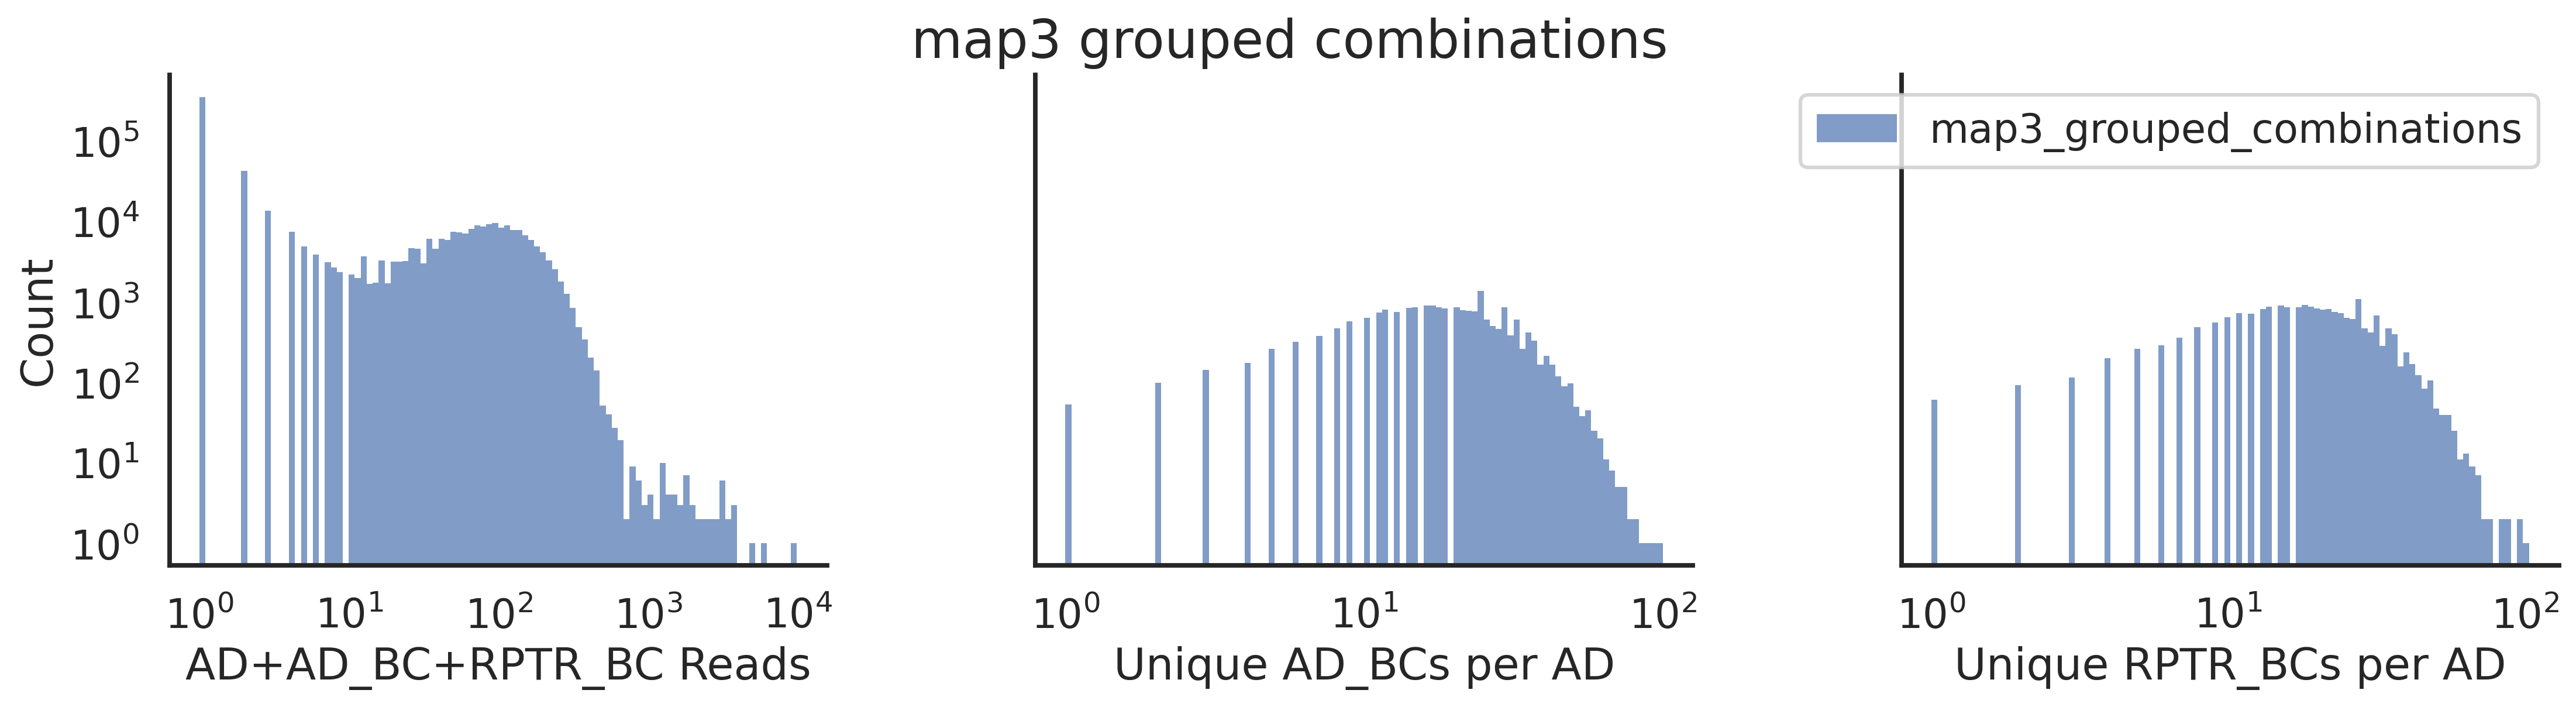

In [8]:
refiner.plot_map_histograms('map3_grouped_combinations');

Processing maps: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


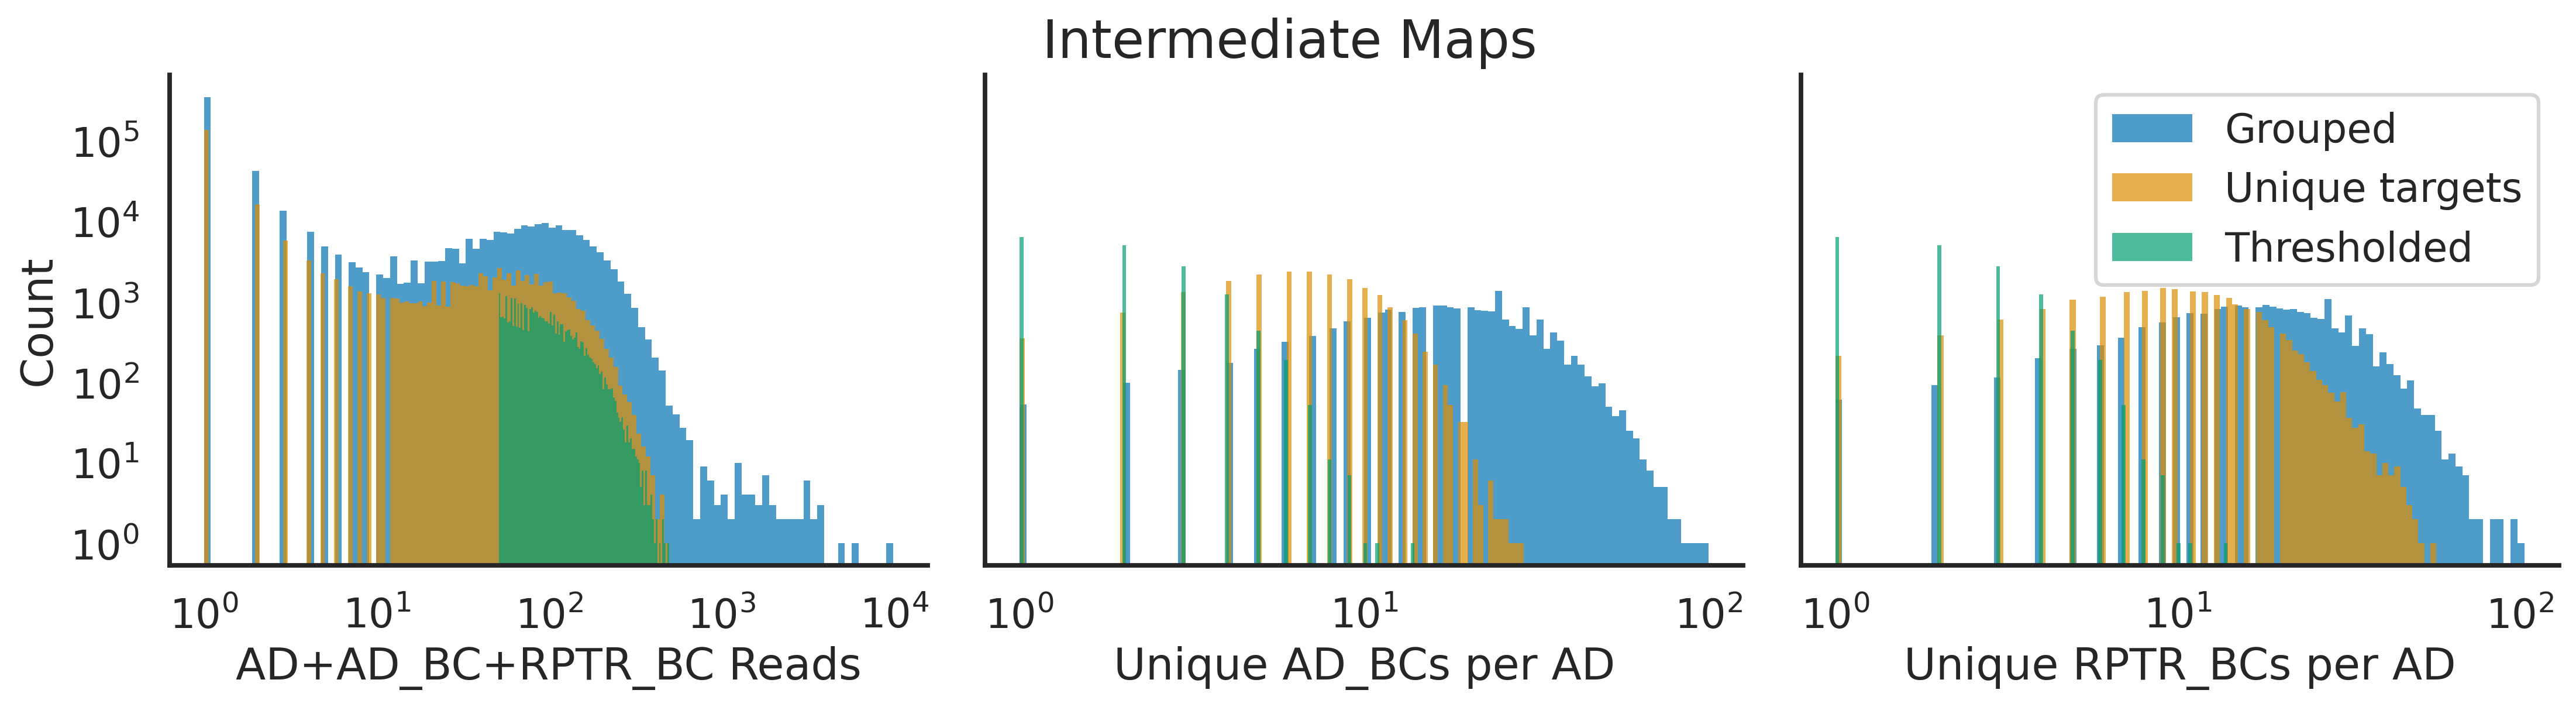

In [6]:
refiner.plot_maps_3to5_histograms();

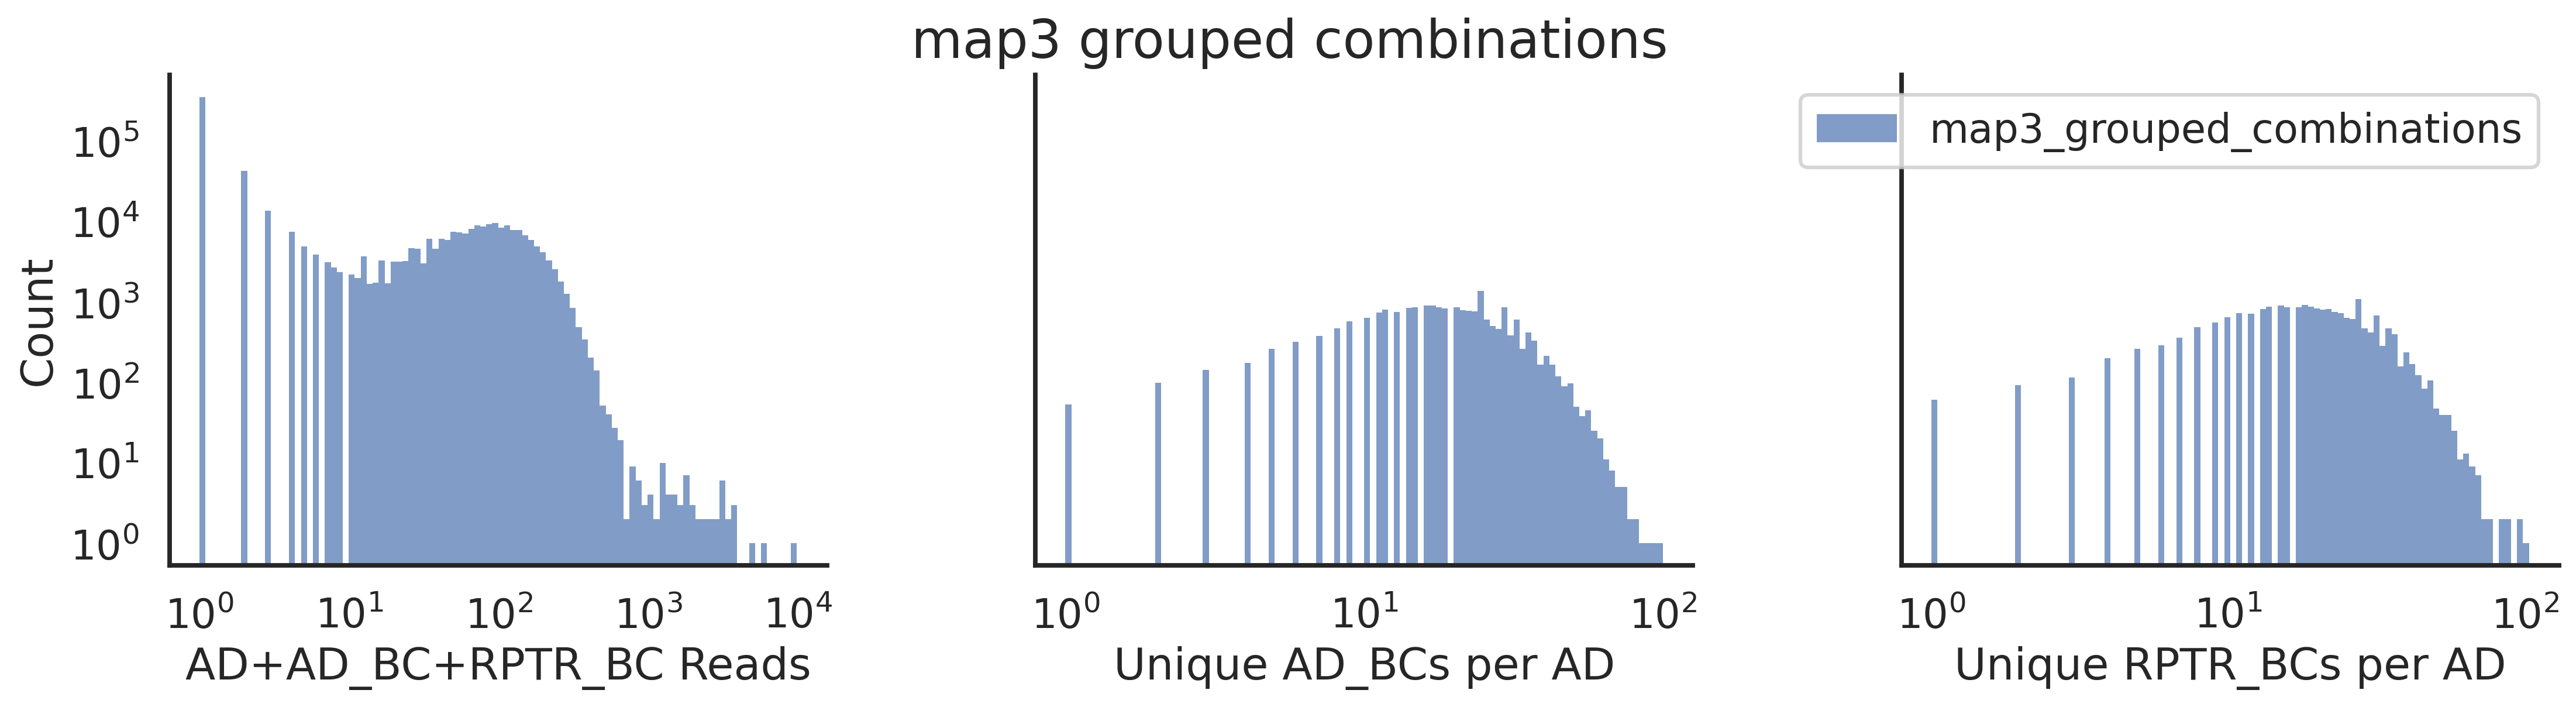

In [7]:
refiner.plot_map_histograms('map3_grouped_combinations');

/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 4500x1200 with 3 Axes>,
 array([<Axes: xlabel='AD+AD_BC+RPTR_BC Reads', ylabel='Count'>,
        <Axes: xlabel='Unique AD_BCs per AD', ylabel='Count'>,
        <Axes: xlabel='Unique RPTR_BCs per AD', ylabel='Count'>],
       dtype=object))

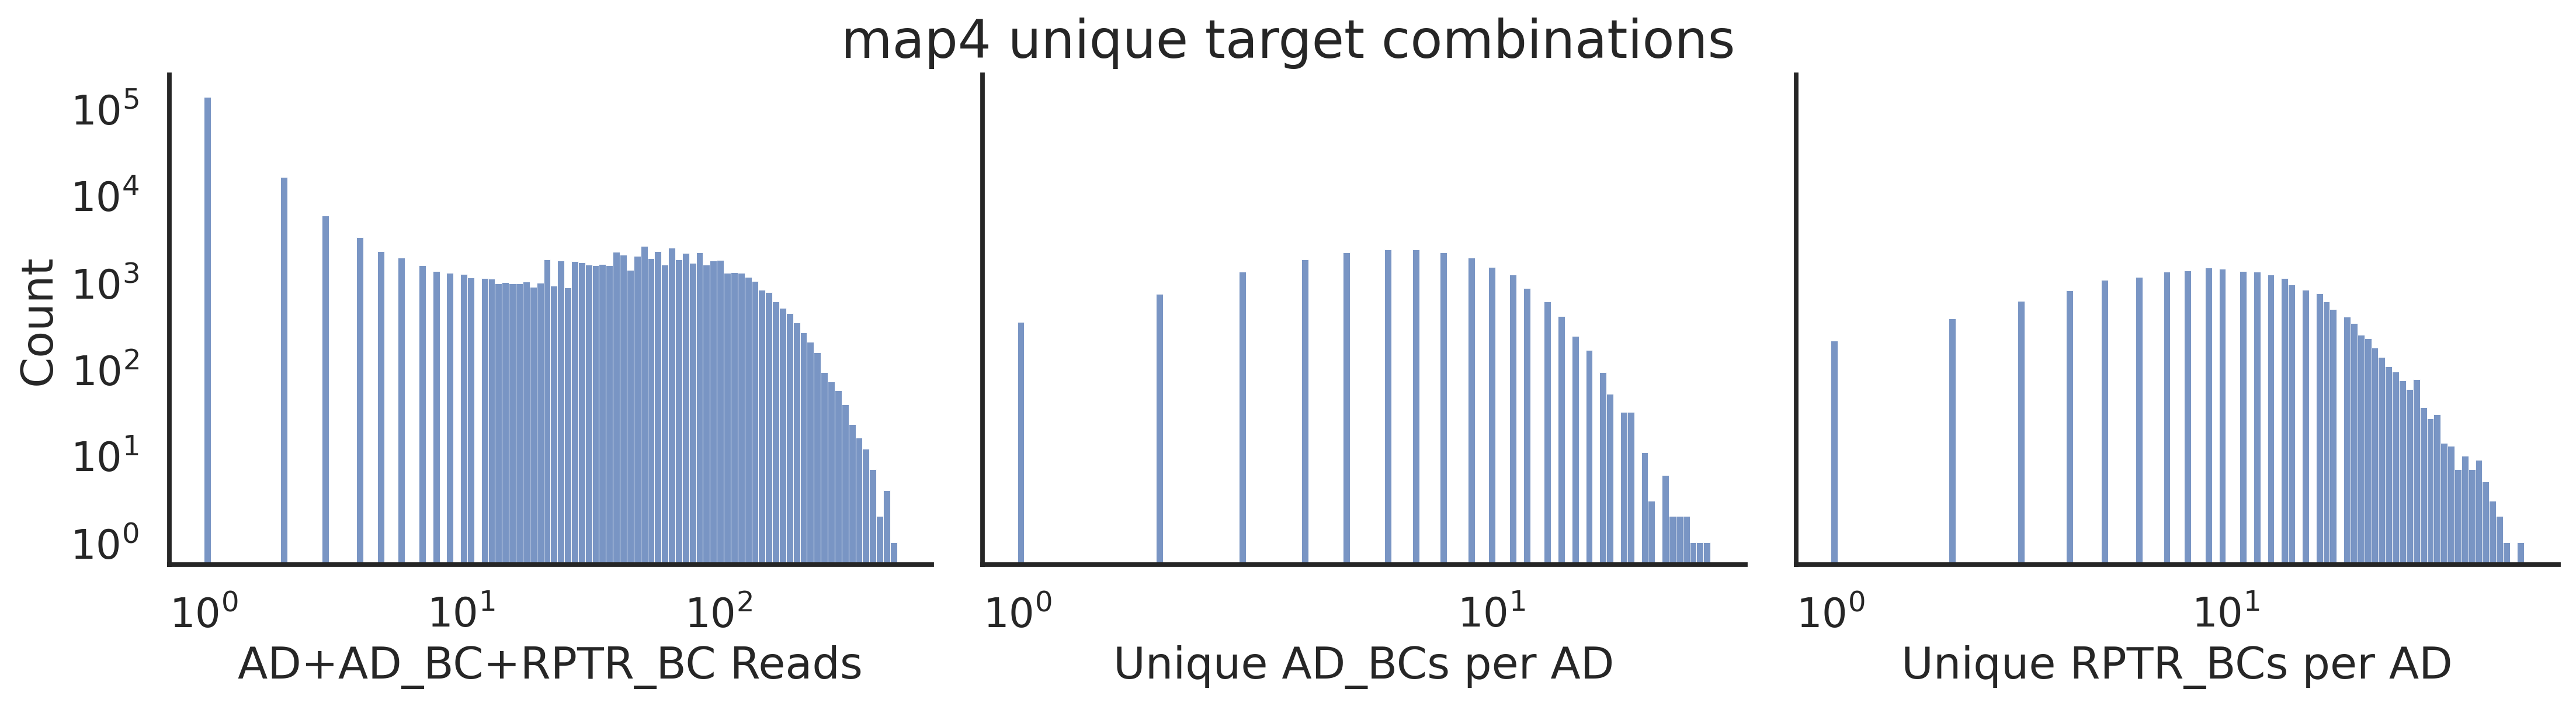

In [3]:
refiner.plot_map_histograms('map4_unique_target_combinations')

/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 4500x1200 with 3 Axes>,
 array([<Axes: xlabel='AD+AD_BC+RPTR_BC Reads', ylabel='Count'>,
        <Axes: xlabel='Unique AD_BCs per AD', ylabel='Count'>,
        <Axes: xlabel='Unique RPTR_BCs per AD', ylabel='Count'>],
       dtype=object))

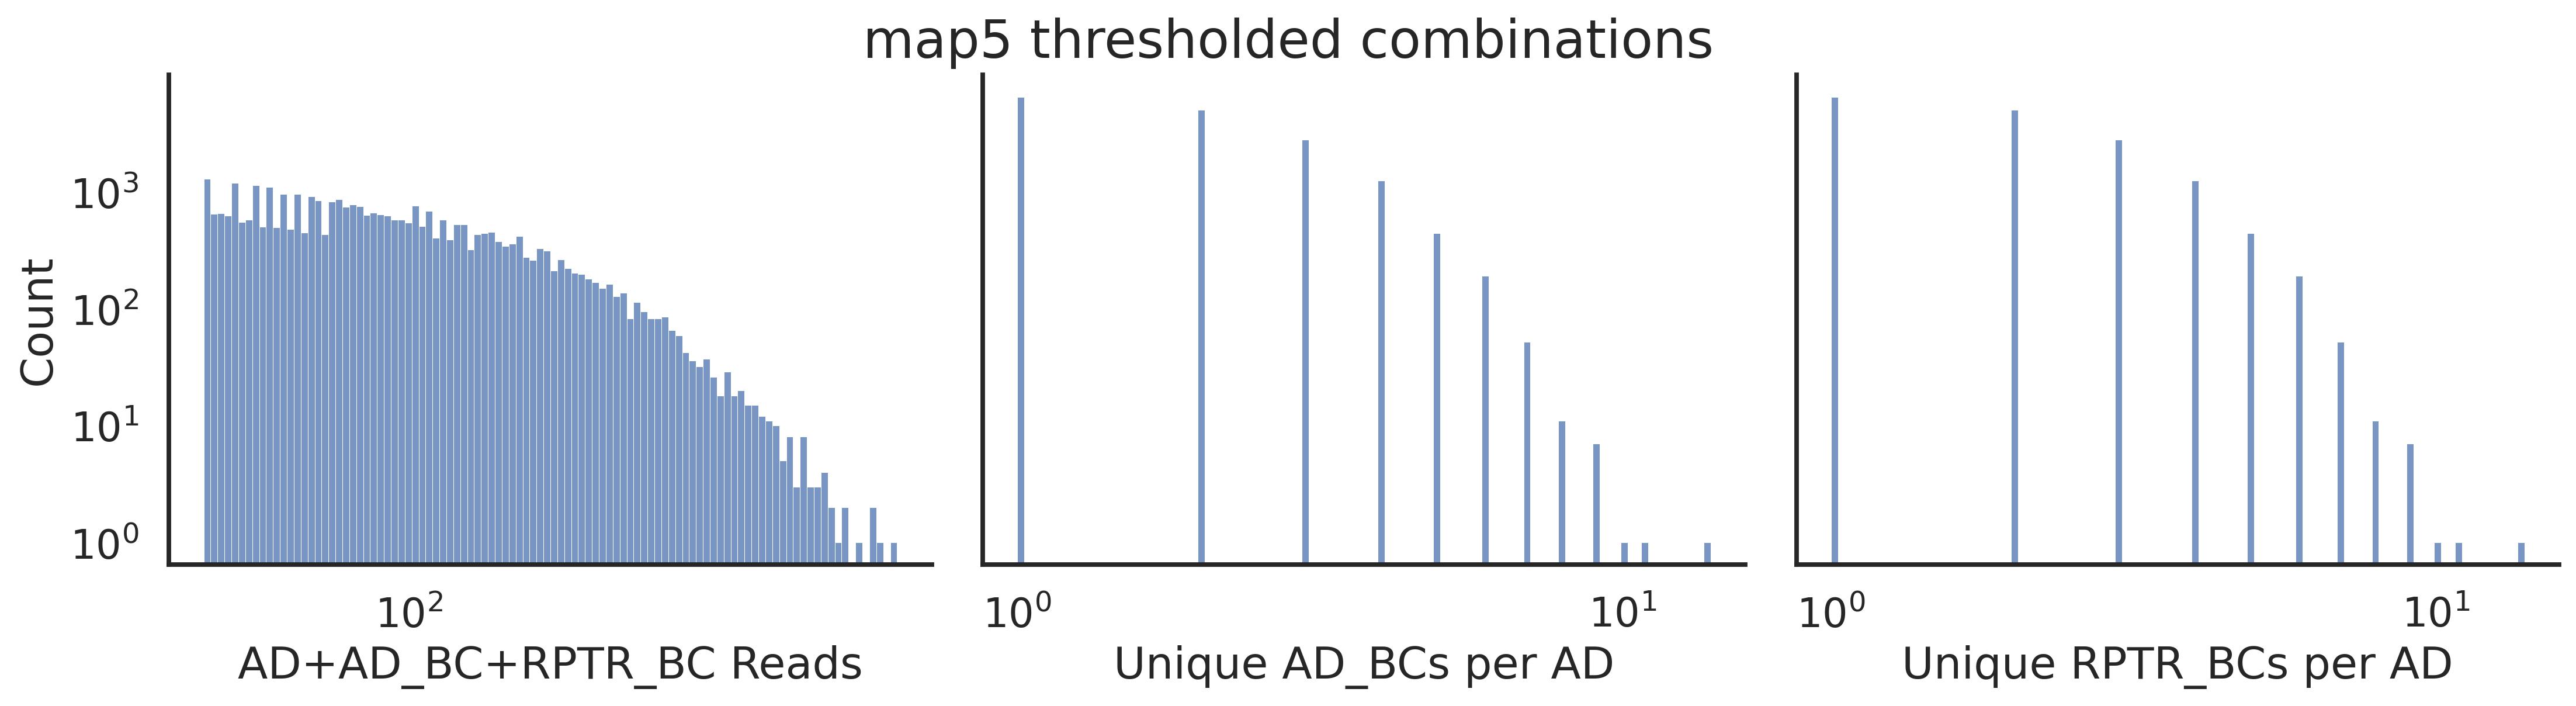

In [4]:
refiner.plot_map_histograms('map5_thresholded_combinations')

In [5]:
refiner.save_loss_table()

,map,description,num_rows,% of previous step,% of total reads
0,map1_initial,Initial combinations,138671404,100.00,100.00
1,map2_quality_designed,After removing low quality and undesigned,17756542,12.80,12.80
2,map3_grouped,Grouped counts,623956,3.51,0.45
3,map4_unique_target,Filtered for unique targets,239182,38.33,0.17
4,map5_thresholded,Filtered by reads_threshold > 50,33672,14.08,0.02


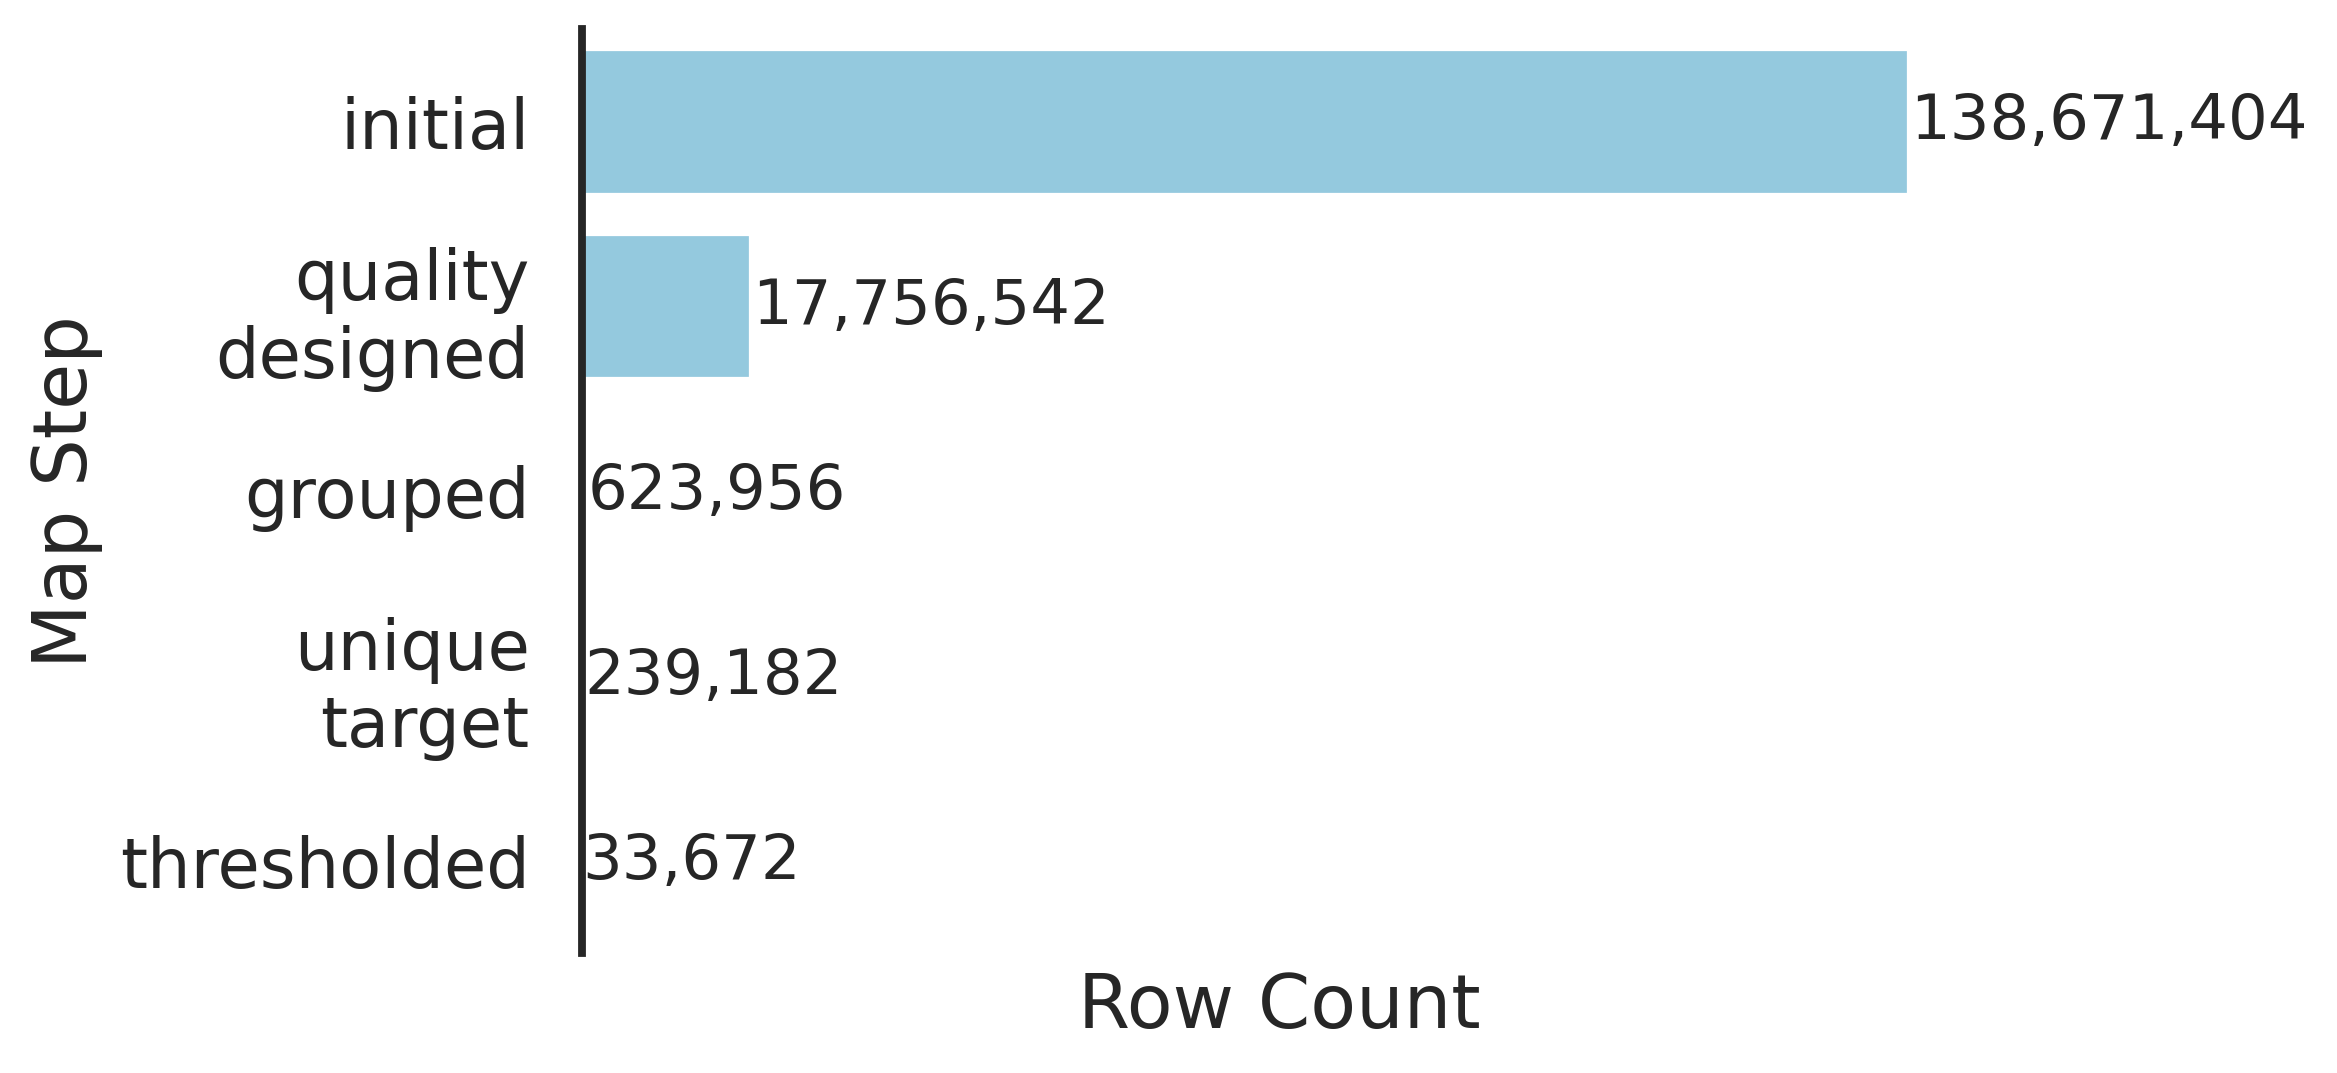

In [6]:
refiner.plot_loss();

/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


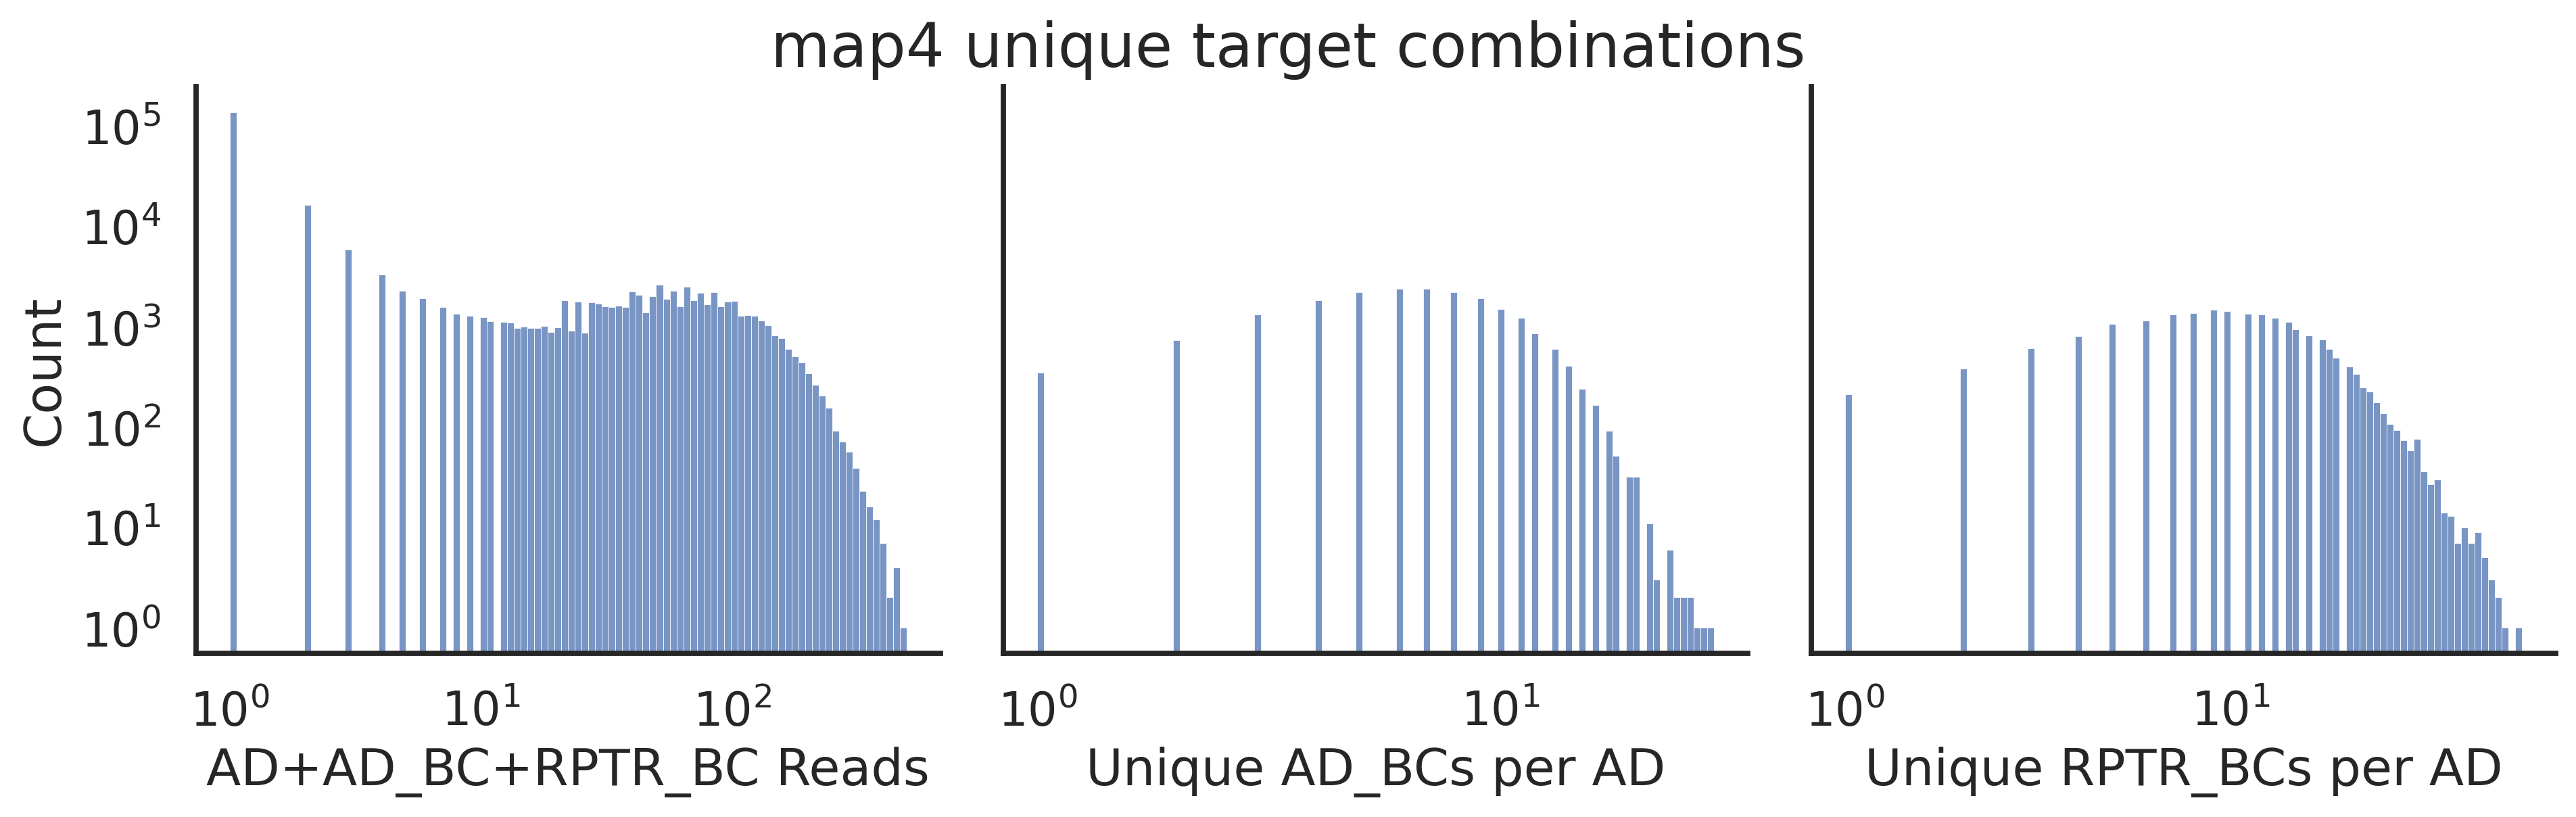

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

map4 = refiner.get_map_df("map4_unique_target_combinations")
cols = ["AD", "AD_BC", "RPTR_BC"]

fig, axs = plt.subplots(1, len(cols), dpi = 300, figsize = (13,4), sharey= True)
axs = axs.flatten()

sns.histplot(map4["count"], bins = 100, log_scale = (True, True), ax = axs[0])
axs[0].set_xlabel("+".join(cols) + " Reads")

sns.histplot(map4[["AD", "AD_BC"]].drop_duplicates().groupby("AD").size(), bins = 100, log_scale = (True, True), ax = axs[1])
axs[1].set_xlabel("Unique AD_BCs per AD")

sns.histplot(map4[["AD", "RPTR_BC"]].drop_duplicates().groupby("AD").size(), bins = 100, log_scale = (True, True), ax = axs[2])
axs[2].set_xlabel("Unique RPTR_BCs per AD")

fig.tight_layout(pad = 1)
fig.suptitle("map4_unique_target_combinations".replace("_", " "), y = 1.02)
sns.despine()


In [75]:
# def plot_map_histograms(map_name, axs=None):
#     """
#     Plot histograms for:
#       1. Read counts per full combination of self.cols
#       2. Unique barcode counts per AD for each barcode type in self.cols[1:]
    
#     Args:
#         self: object with attribute `cols` (list of str: e.g. ["AD", "AD_BC", "RPTR_BC"])
#         map_df: pd.DataFrame containing these columns + "count"
#         axs: optional list/array of matplotlib axes
#     """

#     map_df = refiner.get_map_df(map_name)

#     cols = ["AD", "AD_BC", "RPTR_BC"]

#     plots = []
#     # 1. Reads per full combination
#     plots.append({
#         "data": map_df["count"],
#         "xlabel": "+".join(cols) + " Reads"
#     })


#     # 2. Unique BCs per AD for each bc type
#     for bc in cols[1:]:
#         counts = map_df[["AD", bc]].drop_duplicates().groupby("AD").size()
#         plots.append({
#             "data": counts,
#             "xlabel": f"Unique {bc}s per AD"
#         })

#     # --- set up axes ---
#     nplots = len(plots)
#     if axs is None:
#         fig, axs = plt.subplots(
#             1, nplots, dpi=300, figsize=(5*nplots, 4), sharey=True
#         )
#         axs = axs.flatten()
#         created_fig = True
#     else:
#         created_fig = False

#     # --- plotting ---
#     for ax, p in zip(axs, plots):
#         sns.histplot(
#             p["data"],
#             bins=100,
#             log_scale=(True, True),
#             ax=ax
#         )
#         ax.set_xlabel(p["xlabel"])

#     # --- formatting ---
#     if created_fig:
#         fig.tight_layout(pad=1)
#         fig.suptitle(
#             " ".join(map_name.split("_")),
#             y=1.02
#         )
#         sns.despine()
#         return fig, axs

/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 4500x1200 with 3 Axes>,
 array([<Axes: xlabel='AD+AD_BC+RPTR_BC Reads', ylabel='Count'>,
        <Axes: xlabel='Unique AD_BCs per AD', ylabel='Count'>,
        <Axes: xlabel='Unique RPTR_BCs per AD', ylabel='Count'>],
       dtype=object))

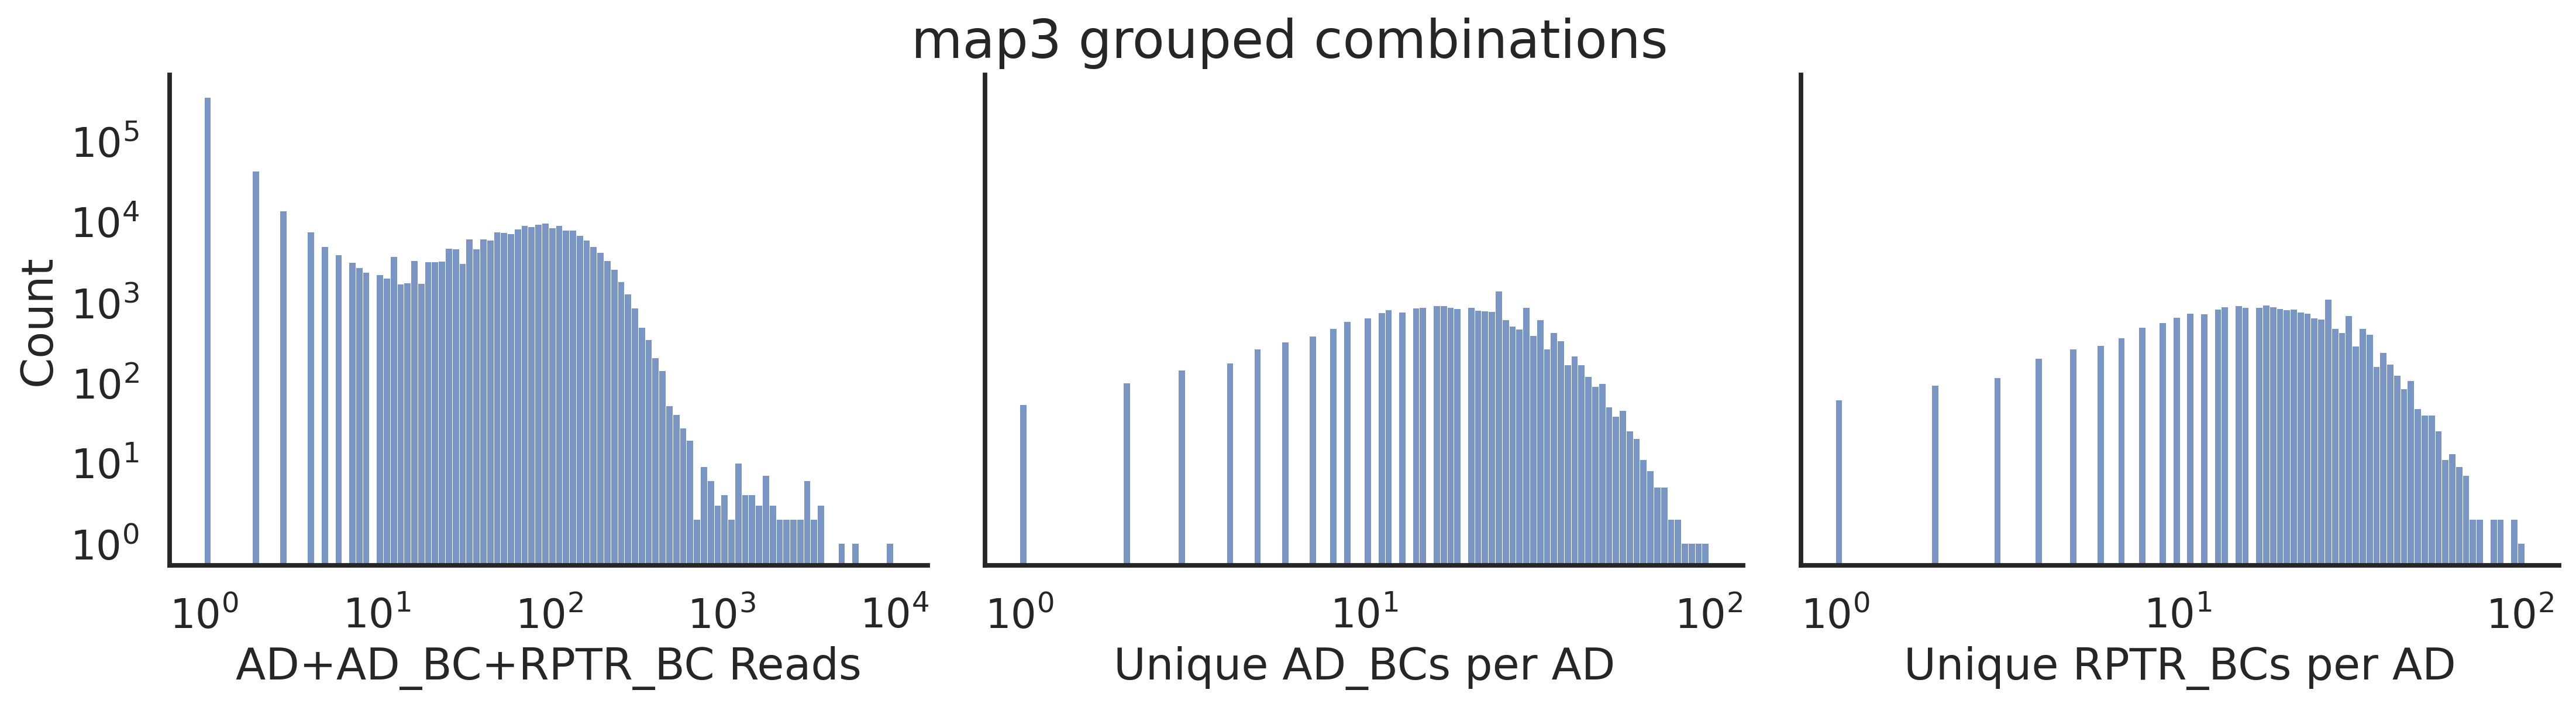

In [74]:
plot_map_histograms("map3_grouped_combinations")

/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 4500x1200 with 3 Axes>,
 array([<Axes: xlabel='AD+AD_BC+RPTR_BC Reads', ylabel='Count'>,
        <Axes: xlabel='Unique AD_BCs per AD', ylabel='Count'>,
        <Axes: xlabel='Unique RPTR_BCs per AD', ylabel='Count'>],
       dtype=object))

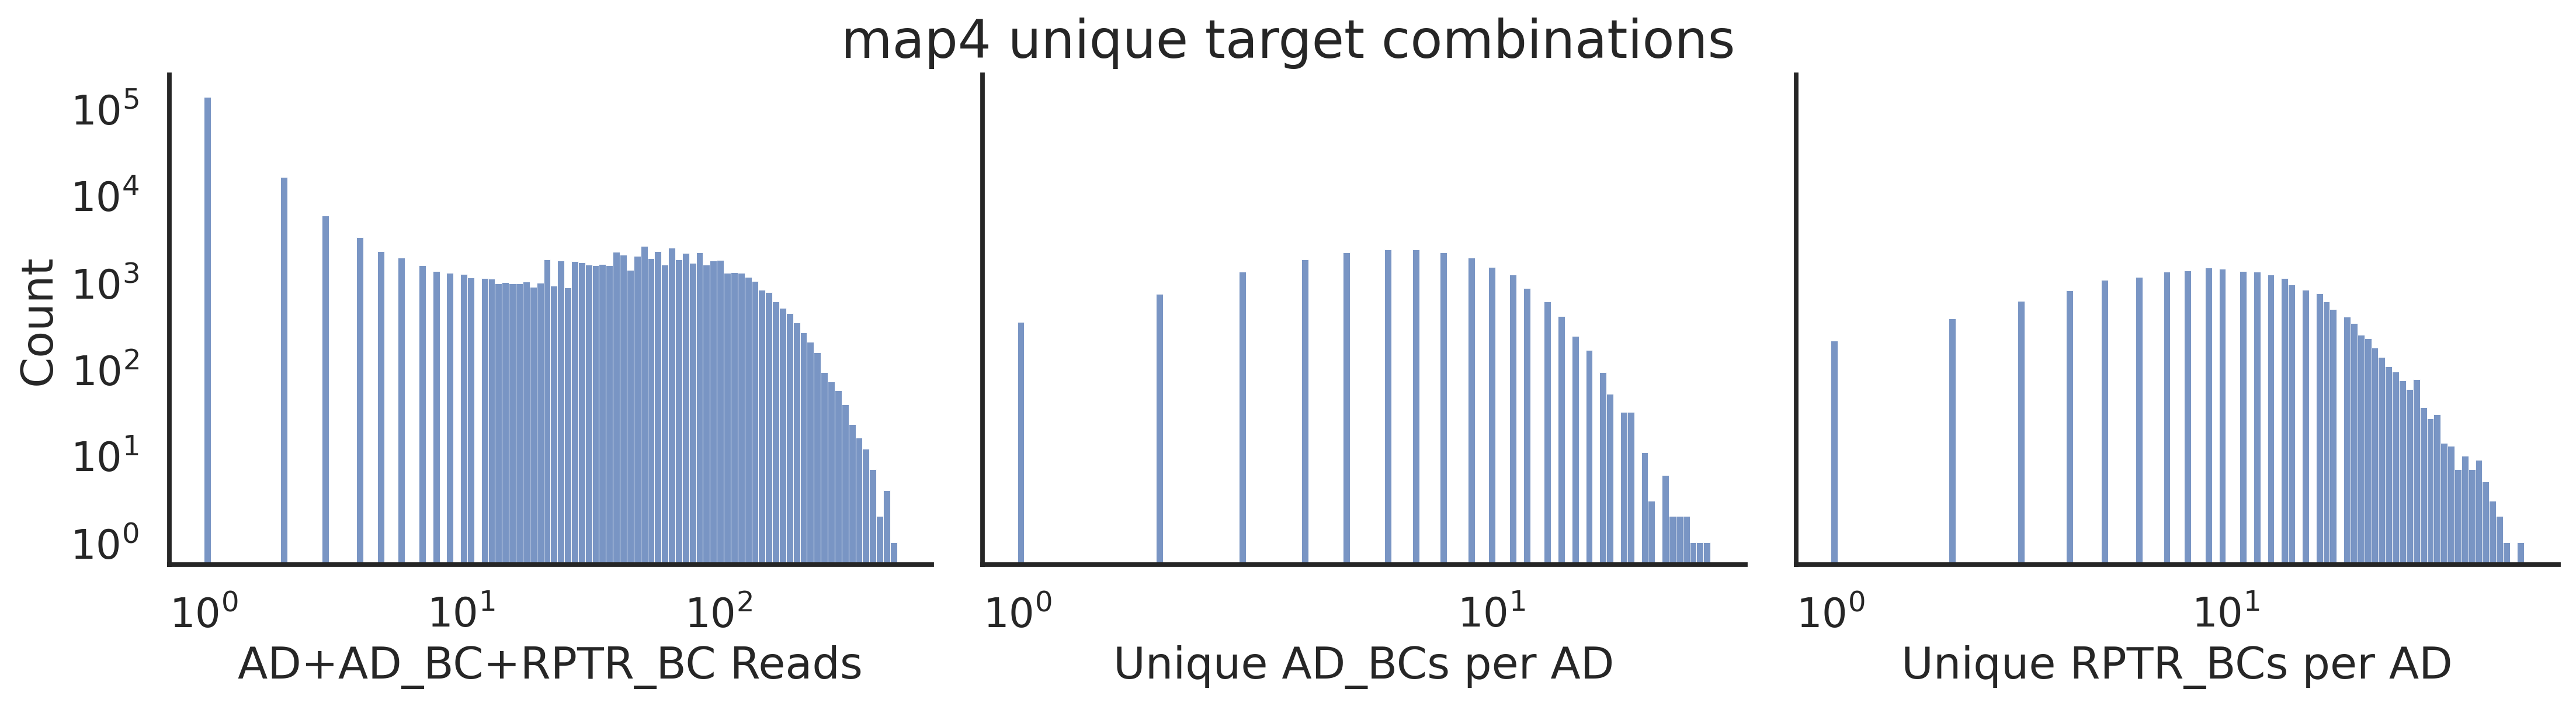

In [68]:
plot_map_histograms("map4_unique_target_combinations")

/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 4500x1200 with 3 Axes>,
 array([<Axes: xlabel='AD+AD_BC+RPTR_BC Reads', ylabel='Count'>,
        <Axes: xlabel='Unique AD_BCs per AD', ylabel='Count'>,
        <Axes: xlabel='Unique RPTR_BCs per AD', ylabel='Count'>],
       dtype=object))

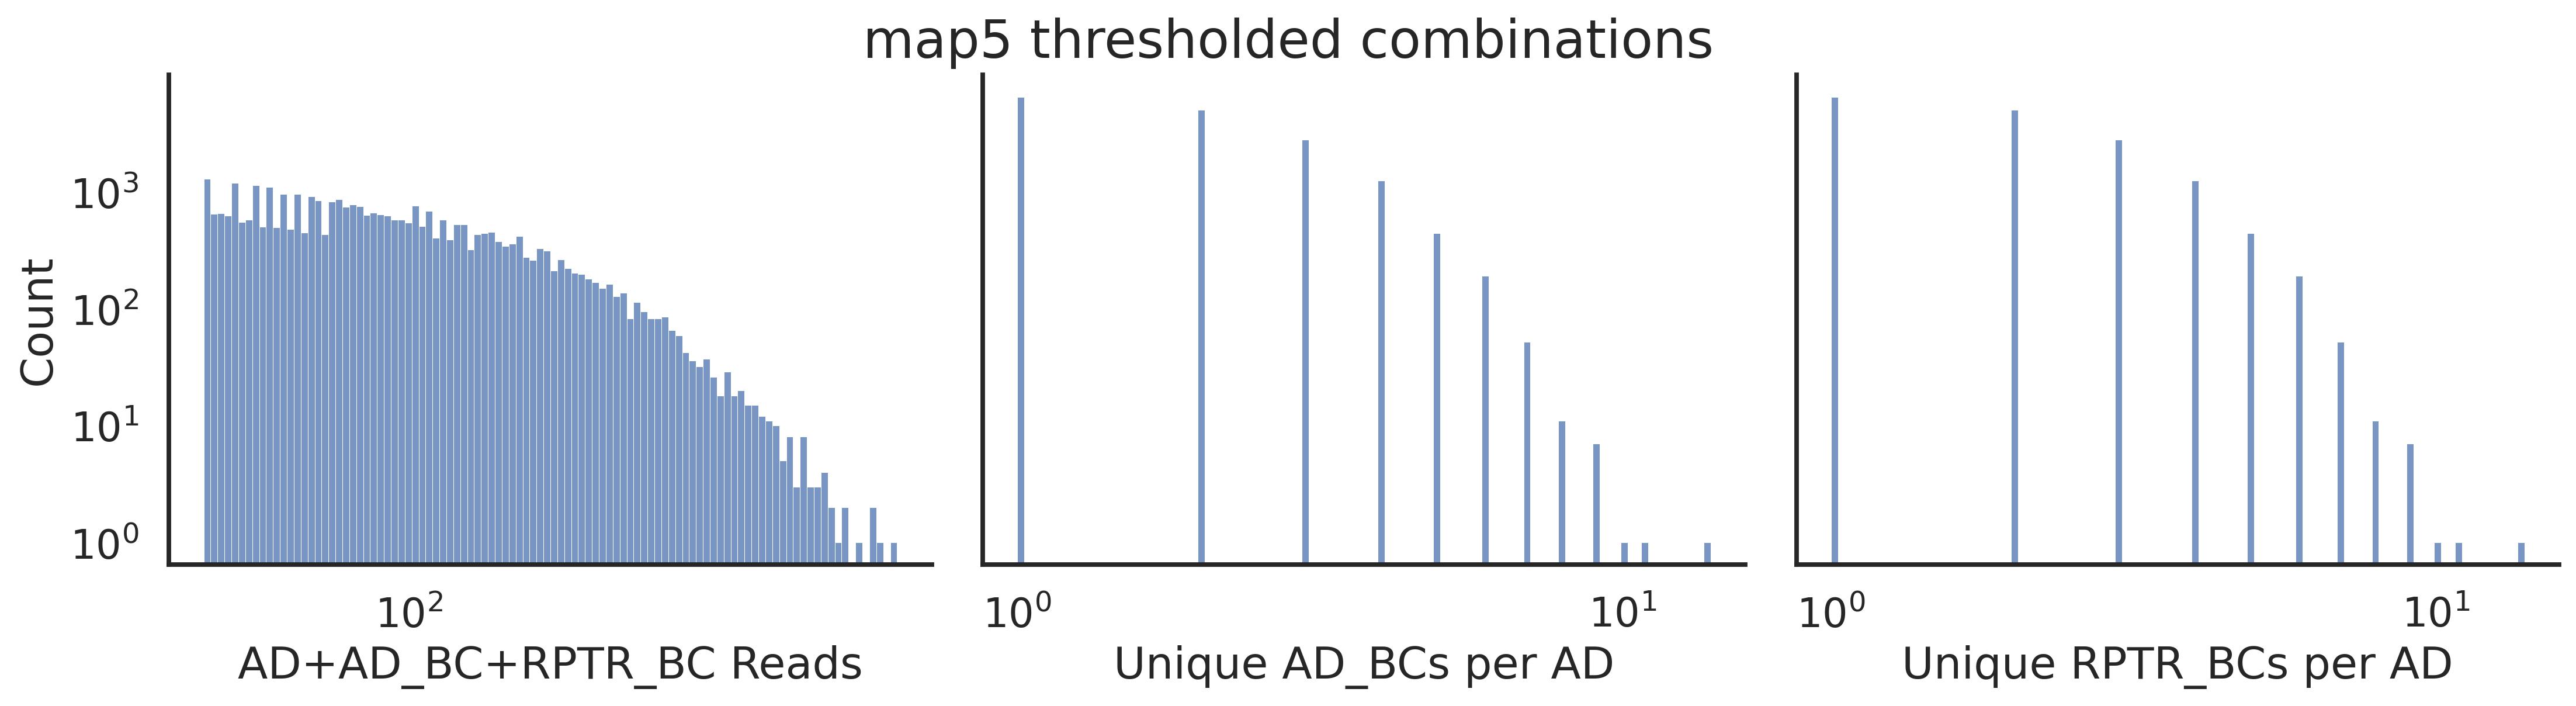

In [69]:
plot_map_histograms("map5_thresholded_combinations")

/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


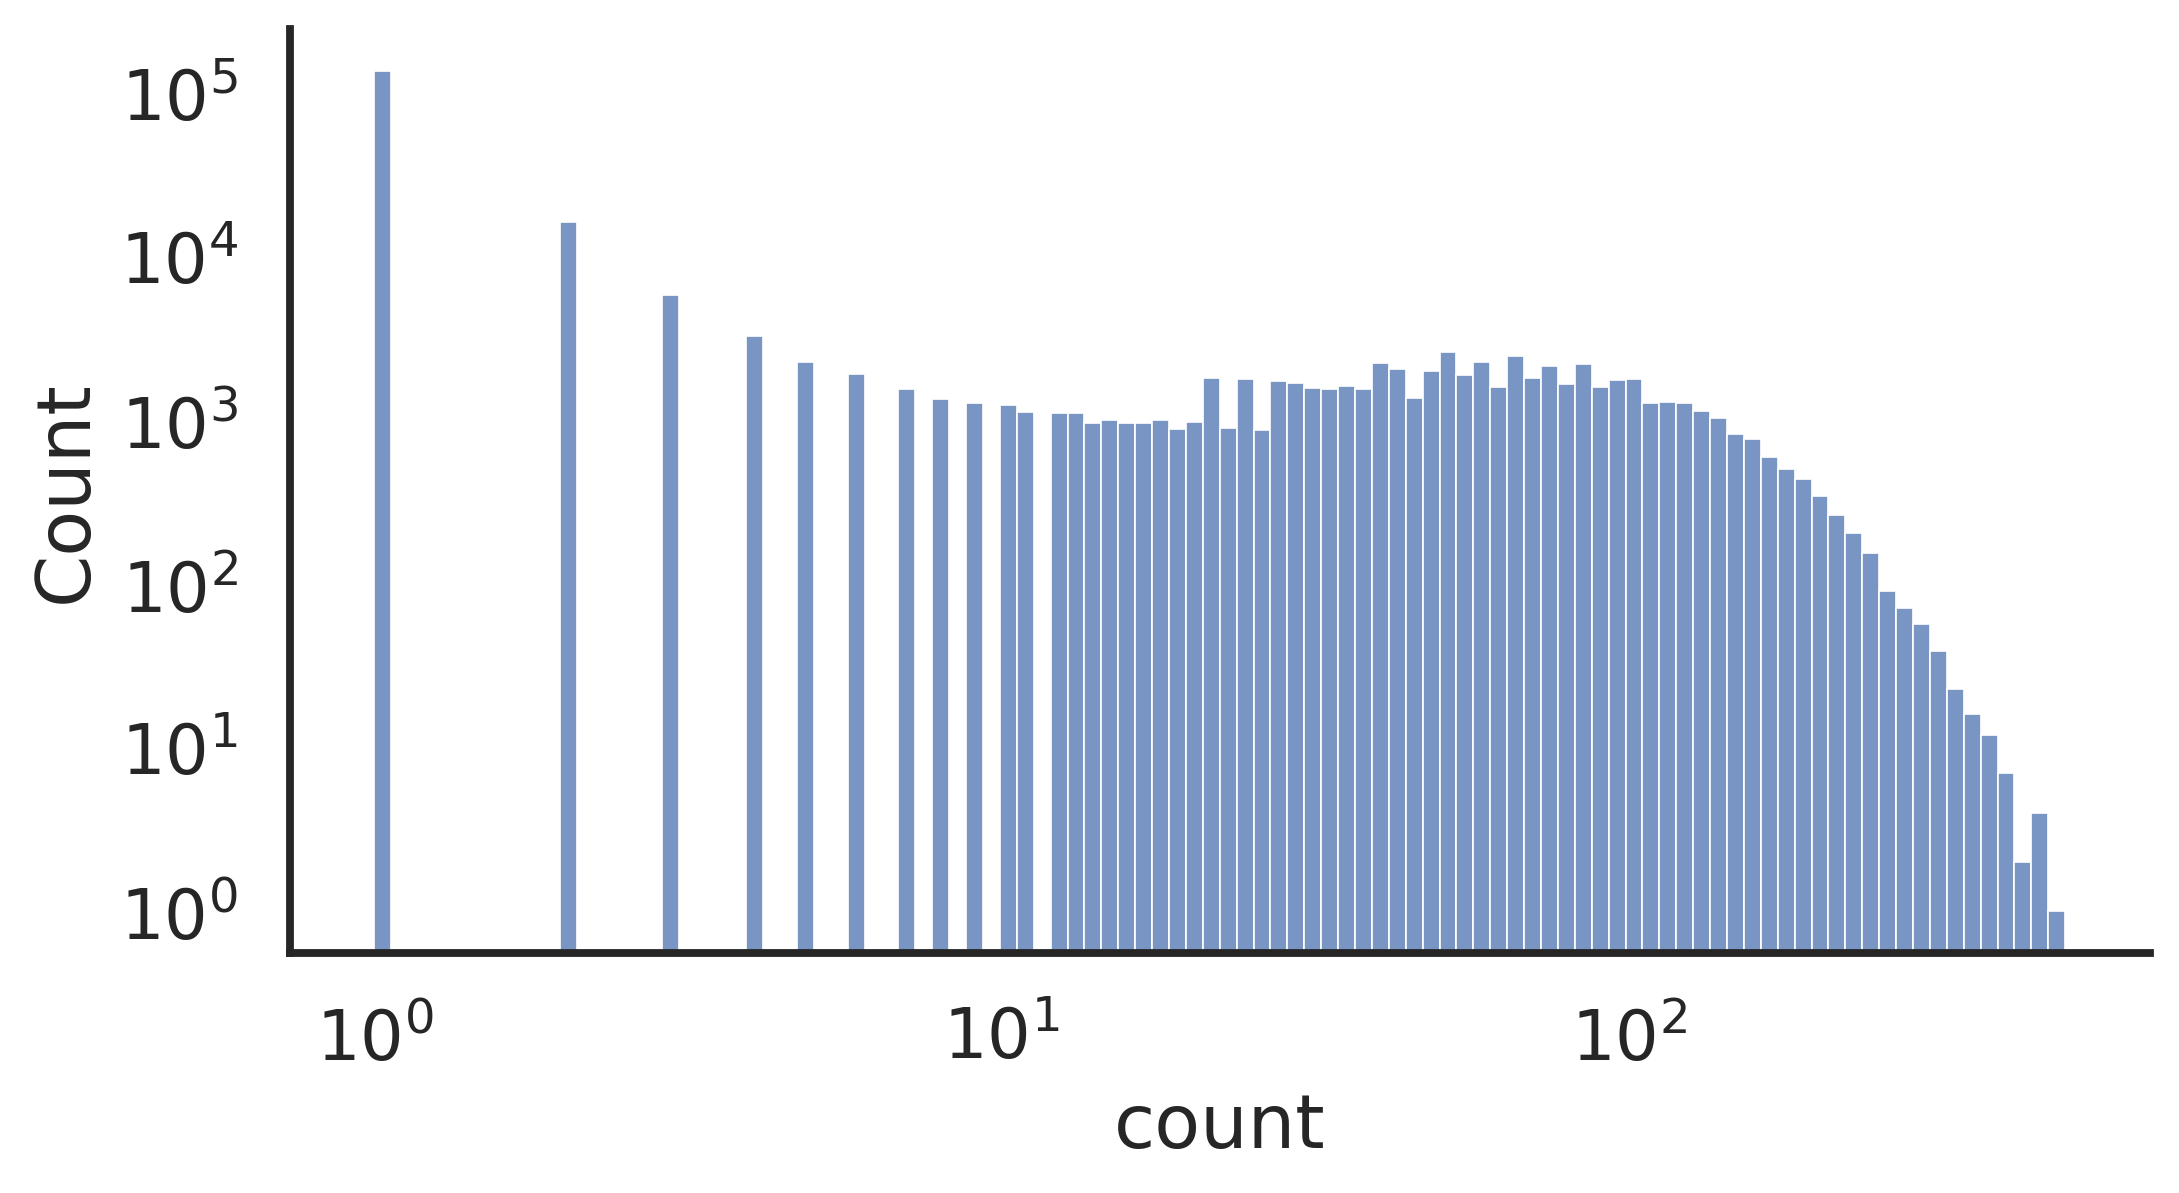

In [7]:
refiner.plot_map4_coverage();

In [9]:
map5 = refiner.get_map_df('map5_thresholded_combinations')
map5

,AD,AD_BC,RPTR_BC,count
0,TCTGCTGATTATTCTGGTTTGCAATCTGATTATTCTCCATTGACTG...,GGTAGAGTTCA,TCCAAGTAAAGCAT,496
1,GGTTCTTGTTTGCCAATTTCTTCTACTCCAAGAGAACAATGGAGAT...,CGACCCCGCCT,GAGGCGCGTTACTC,465
2,TCTACTGATTCTACTCCAATGTTTGAATATGAAGGTTTGGAAGATA...,CGTTAAGCTTC,GGGTAATCTCCACA,456
3,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...,GCCTGCTCGGG,ATAAAGCTATGCTG,454
4,TCTCCATATGGTGATTCTTATGATGTTTCTCCAAACTTTGGTGGTA...,CCACCAGGTGA,GAGTTCTCTAGTGC,442
...,...,...,...,...
33667,GATTTGTCTATGTTGTCTCCACAACAAATTCCAACTGGTATTATGG...,AATCACCTCGG,AAAATTTTGATAAG,51
33668,CAACCAACATTTAATAATGGTCAACACTTCTATGCTAATTCTGCTC...,TTGATTTCAAA,TTGATTTCGCACAT,51
33669,TCTCCATCTGCTGGTCAAAGAGCTAGATTTGTTAATGCTTCTTCTT...,CCATACGAGCT,CCCTGGCCAACATG,51
33670,TTGTCTTCTCCAGCTCCACATGCTTCTAGACAACCATTGAATACTT...,GCAAACATGCA,GAATAATAGACTTA,51


In [ ]:
# For BC in list of BCs, unique count per AD


In [3]:
# refiner.refine_map_from_parquet('/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/SK_CURRENT_A10_1_tbcRAW_v2.parquet/*.parquet')

In [5]:
df

,map,description,num_rows,% of previous step,% of total reads
0,map1_initial_combinations,Initial combinations,138671404,100.00,100.00
1,map2_quality_designed_combinations,After removing low quality and undesigned,17756542,12.80,12.80
2,map3_grouped_combinations,Grouped counts,623956,3.51,0.45
3,map4_unique_target_combinations,Filtered for unique targets,239182,38.33,0.17
4,map5_thresholded_combinations,Filtered by reads_threshold > 50,33672,14.08,0.02


In [18]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Get loss table with '% of previous step'
# df = refiner.save_loss_table()

# # Set plot style
# sns.set(style="white", context='talk')

# # Create figure and axes
# fig, ax1 = plt.subplots(figsize=(8, 4), dpi=300)

# # Horizontal bar plot
# sns.barplot(x="num_rows", y="description", data=df, ax=ax1, color="skyblue")

# # Format y-axis labels (map descriptions)
# ax1.set_yticklabels(
#     df["map"]
#     .str.split("_").str[1:]
#     .str.join(" ")
#     .str.split(" combinations").str[0]
#     .str.replace(" ", "\n")
# )

# # Add labels at the end of each bar
# max_rows = df["num_rows"].max()
# for i, row in df.iterrows():
#     x = row["num_rows"] + 0.01 * max_rows  # offset to right
#     # Main number
#     ax1.text(x, i, f'{row["num_rows"]:,}', va='center', fontsize='x-small', ha='left')
    
# # Axis labels
# ax1.set_xlabel("Num Rows")
# ax1.set_ylabel("Map Step")

# sns.despine()
# plt.tight_layout()
# plt.show()


In [17]:
import pandas as pd
map4 = refiner.save_map("map4_unique_target_combinations", "map4_unique_target_combinations.csv")
map4 = pd.read_csv("map4_unique_target_combinations.csv")
map4

,AD,AD_BC,RPTR_BC,count
0,GGTTCTTCTGGTCAAATTTCTGATGTCTTGTTTACTTTGTTGATTA...,GGCCTTTCTGA,ACTTAGTTTAGATG,1
1,GTTAATGCTAGGAAGAGAGATAAACCATTGCCACCAATTGTTGTTG...,AAAGGATGATC,TGACGTAACGATAG,1
2,CAACCACCAACTAGAGGTATTAATTTGAATCAACAACATAGATCTC...,TCAAGGATTGA,CAGCAGACTAATTA,1
3,TCTGCTCAATTGCCATCTGATATCTTGTATTCTCCATTGTCATTTG...,ACAAAAAATAC,ACTATTAATTAACT,1
4,TCTAATCATAGAAGAGCTGATATTGATTTGTTTGATGACTTTACTT...,CGCTTAAGCTA,CCACCATCTGTAAA,1
...,...,...,...,...
239177,AATATGTTGTCTCAAGTTCAGAATAATAATAATATTCCAAATATGT...,AGTCTGACCCG,AGAAACCCGCCACG,1
239178,GTTTCTGCATTTGGTTCTTTGCATAATCATAATGCTTCTACTAGAA...,CAATTATACAC,CCTGAATCTTCTTC,1
239179,ACTTCTGATGATATTACTTTGGGTGTTAAACCAACTATGTTGTCTC...,CTAAGATCATG,TTATTAATATCATA,1
239180,TCTCCACATCAATTCTATGCTTCTTCTGCTCCATCTTCTACTACTG...,ATAACGTTAGG,AAGGTGTTACCCAG,1


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt


/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


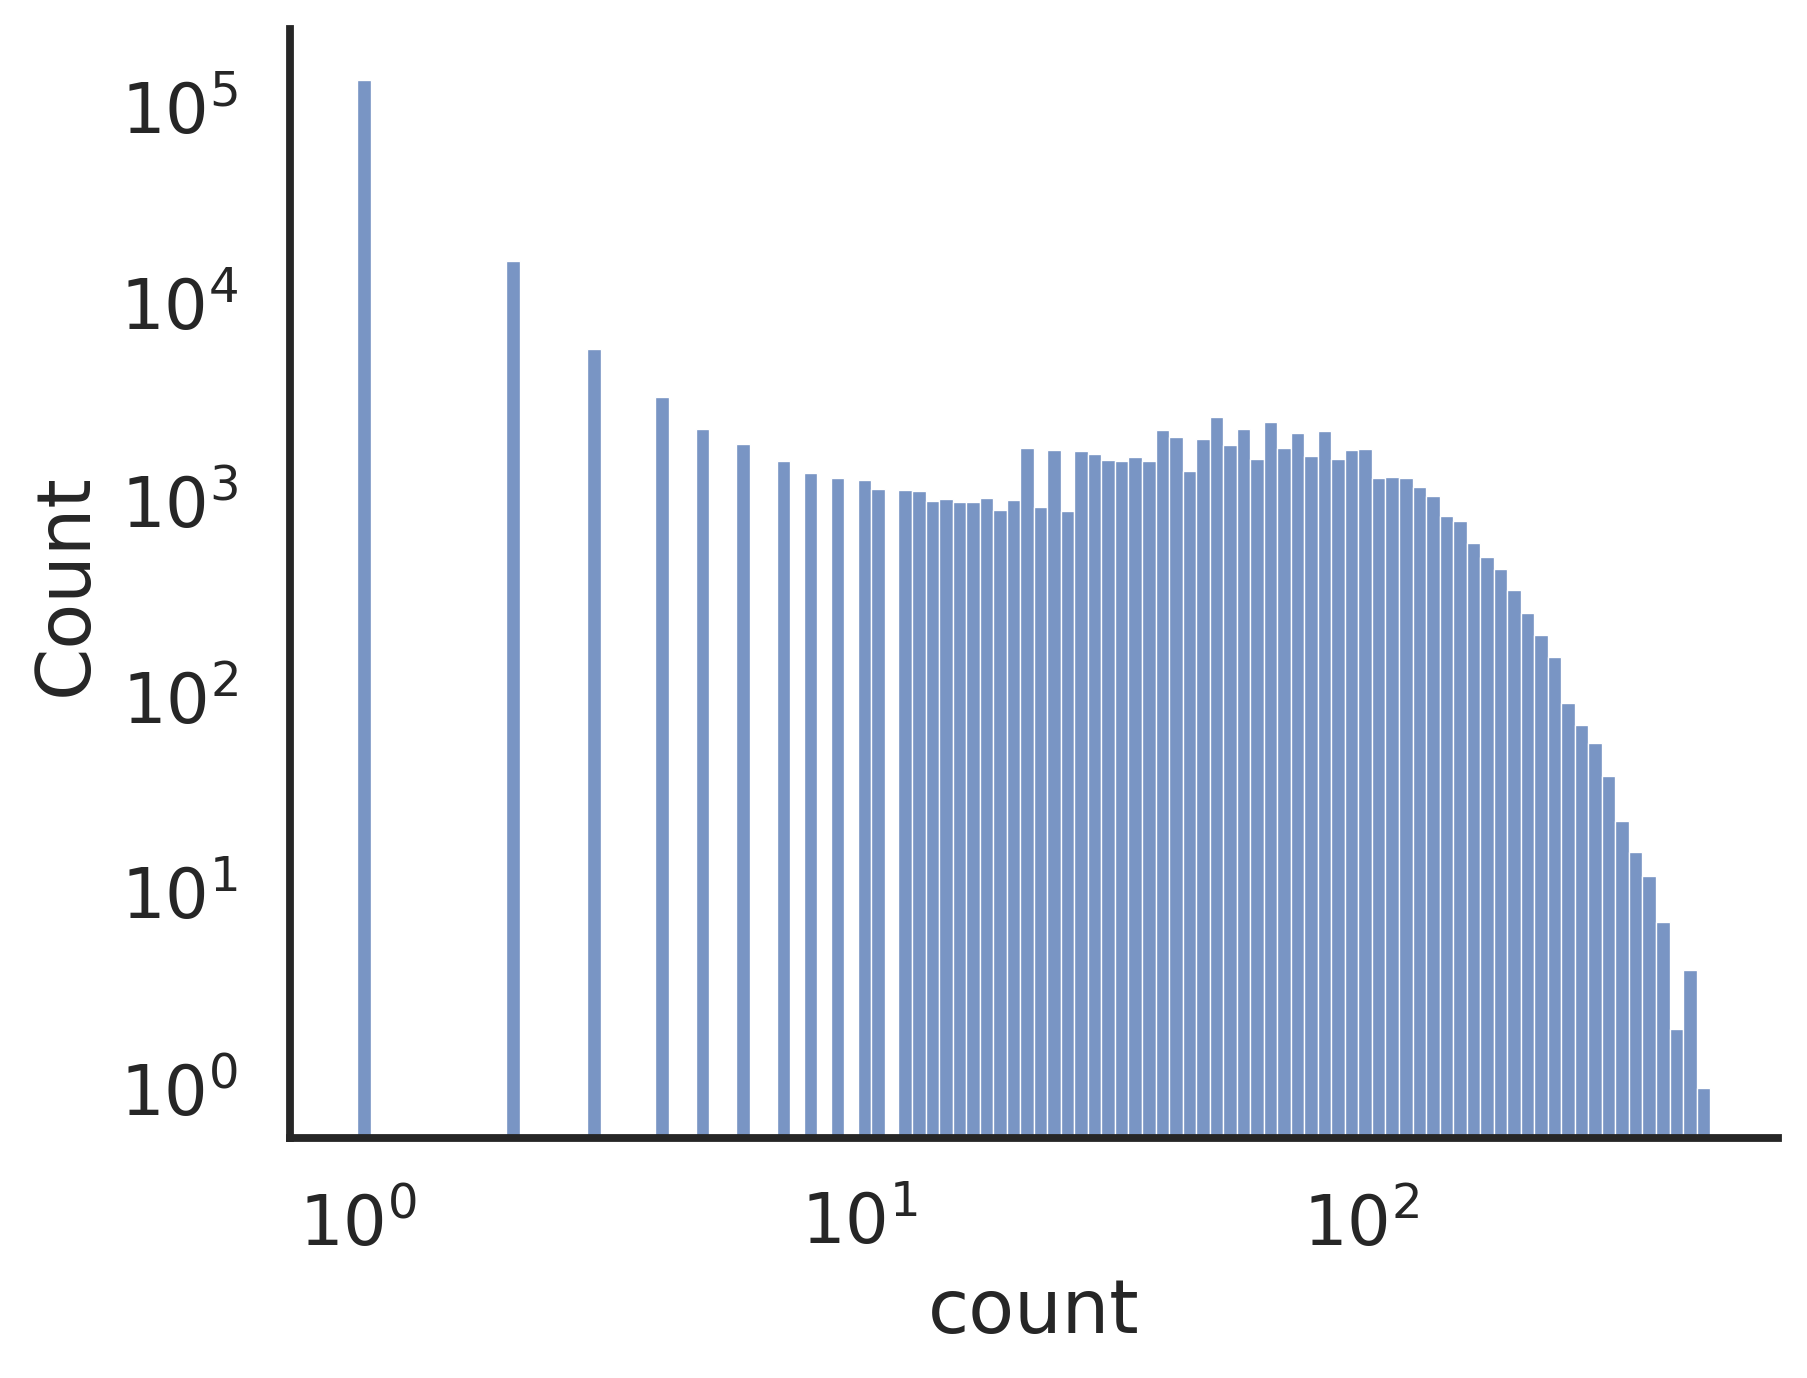

In [23]:
# Plot 1: TBB counts
plt.figure(dpi = 300)
sns.set_context('talk')
sns.histplot(map4["count"], bins = 100, log_scale = (True, True))
sns.despine()

In [ ]:
# For each BC type, unique count per AD


AttributeError: 'Axes' object has no attribute 'seft_xlabel'

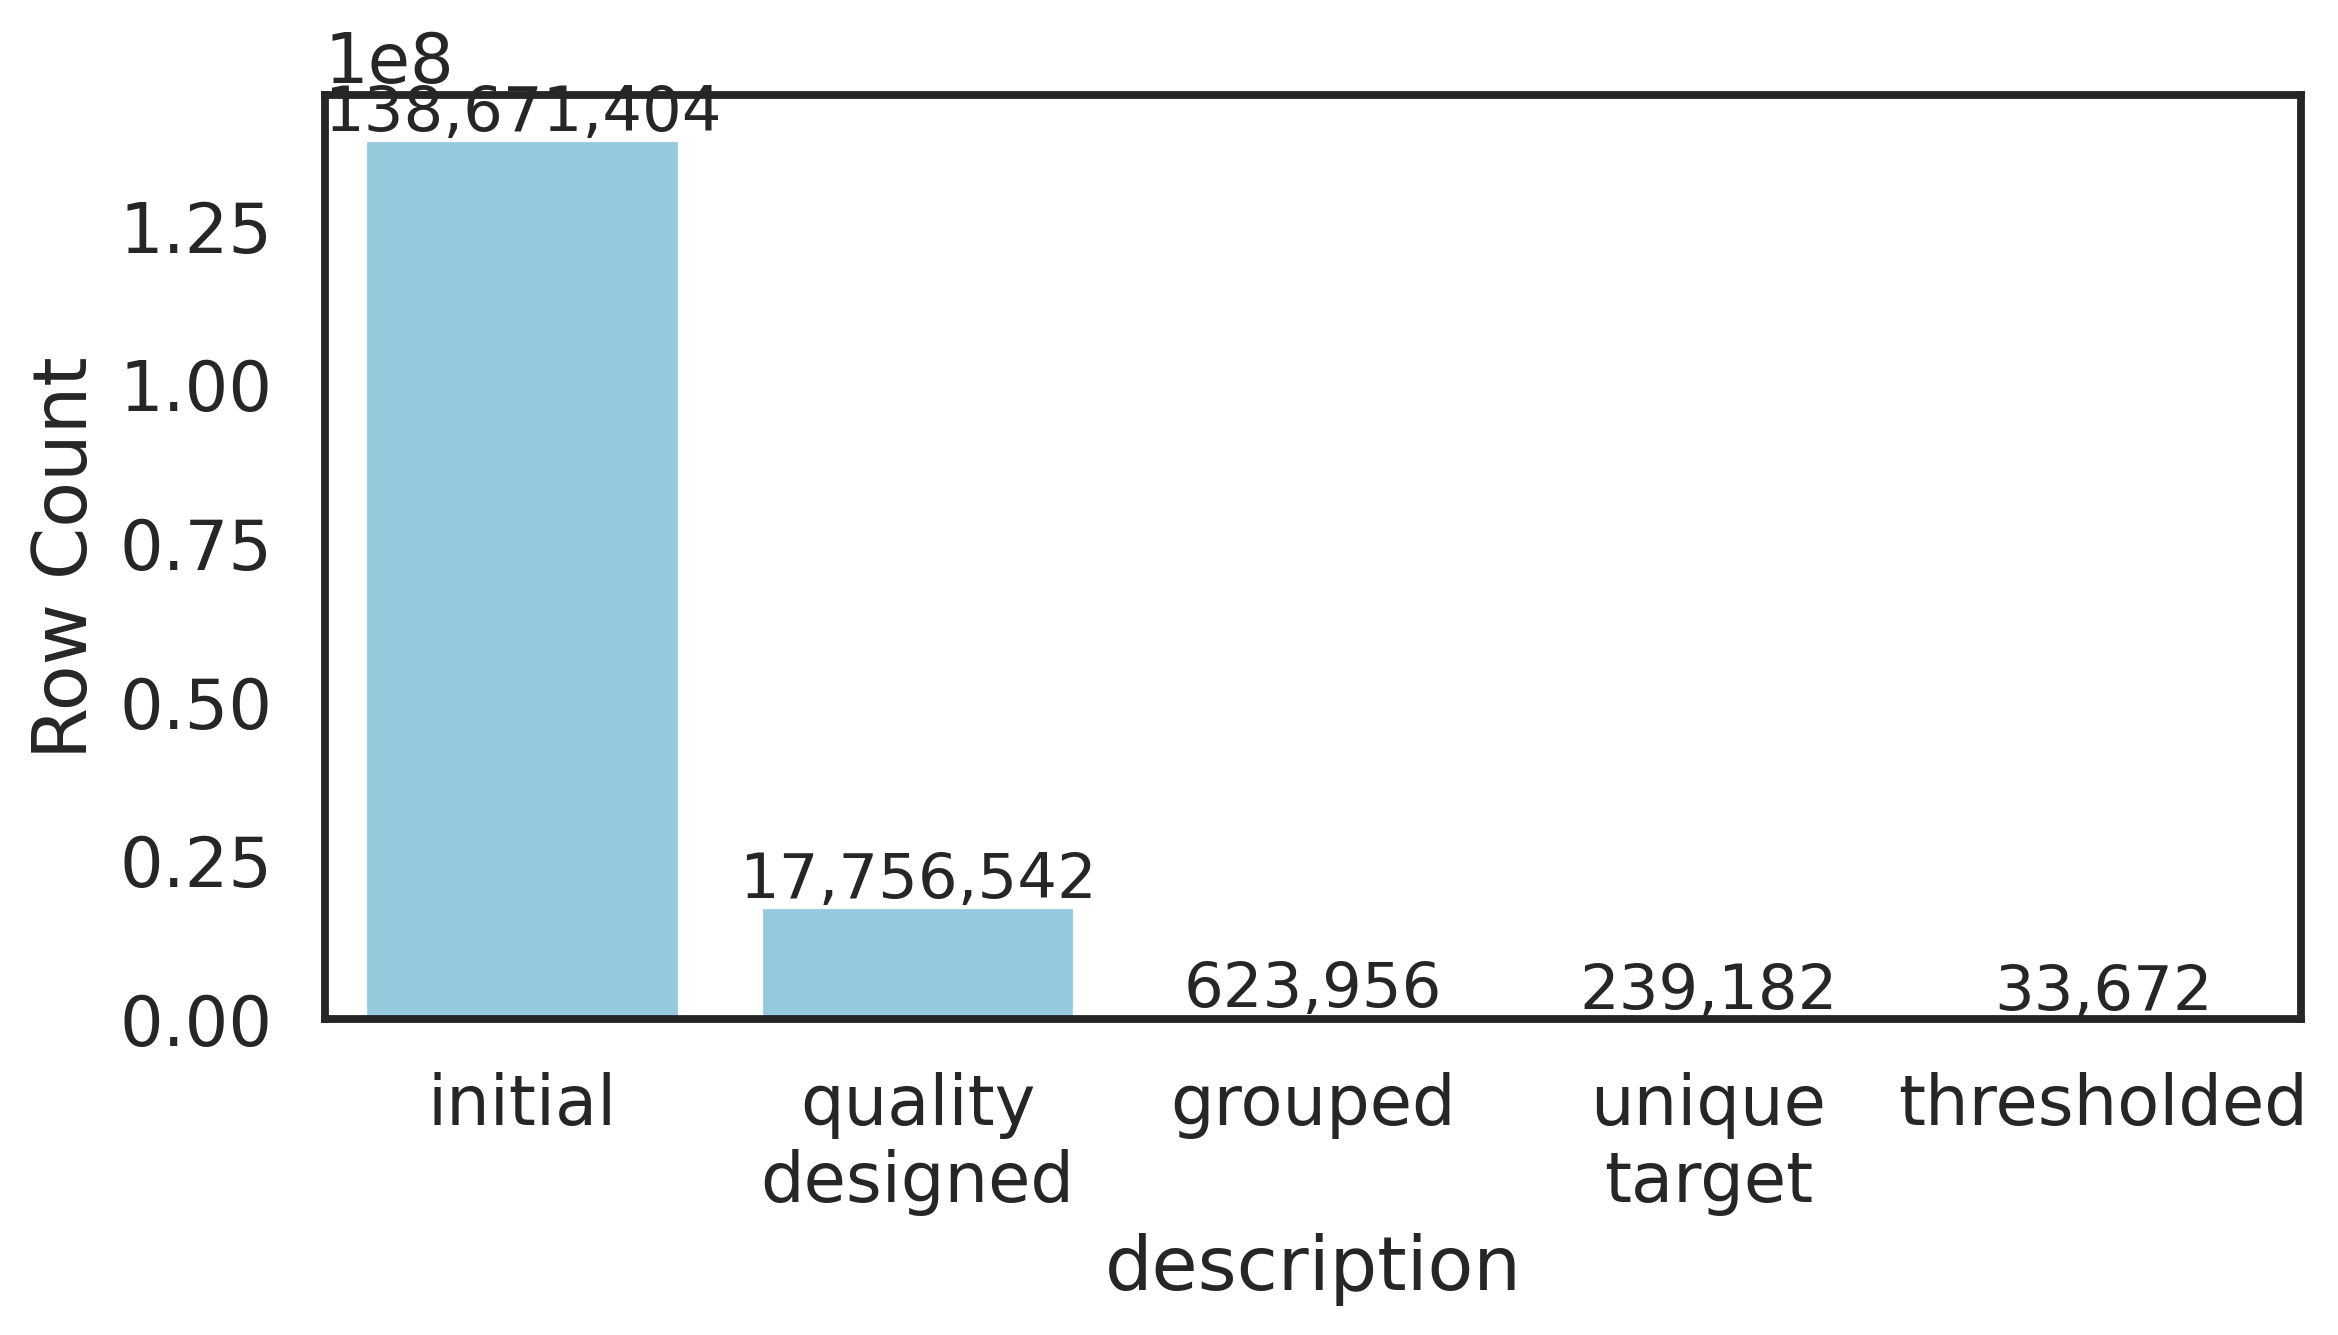

,map,description,num_rows,% of previous step,% of total reads
0,map1_initial_combinations,Initial combinations,None,None,None
1,map2_quality_designed_combinations,After removing low quality and undesigned,None,None,None
2,map3_grouped_combinations,Grouped counts,None,None,None
3,map4_unique_target_combinations,Filtered for unique targets,None,None,None
4,map5_thresholded_combinations,Filtered by reads_threshold > 50,None,None,None


In [75]:
os.chdir("scripts")
from map_loss import LossTable
os.chdir("..")

In [76]:
loss_table = LossTable(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/analysis_test.db",
                     cols = ["AD", "AD_BC", "RPTR_BC"])

TypeError: LossTable.__init__() missing 2 required positional arguments: 'reads_threshold' and 'column_pairs'

In [60]:
con2 = duckdb.connect("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/analysis_test.db")
con2.execute("SELECT * FROM map5").fetchdf()

,AD,AD_BC,RPTR_BC,count
0,TTGCCACCACCACAATCTGTTAGACATTTGCCAAATGATAATTCTG...,TGAACTGATGT,TCTAACATGTGCTG,54
1,GTTAAACAACCATCTACTACTCCATTGGATTCTCCAGCTCCATTGA...,AAATAAAAAAT,AAAAAGTCCAAATT,54
2,TTCTCTGTCTTTACTACTGATTCTTTGCAACAATCTTGGTTGCCAT...,CTTAGGATGCG,ATGTTAATTGGAGA,54
3,AATACTTTGGCTGCTAGAGAATCTAGACAAAGGAAATTTGATCATG...,ATCTACGGCCG,CTGTCCGCAGGGGT,54
4,GATGCATTCTTCTCTTCTACTTCTGATTCTACTCCAATGTTTGAAT...,GTGGCGTTTTC,AGTTTTAATGTCCG,54
...,...,...,...,...
121813,TTTACTAATTTGACTTCTCCATCTACTTATAATGAATCTCCAGAAT...,AATTATTAACT,GTCAAGCATGTACA,54
121814,CCAGTTACTGCTTTGTCTTCTGGTTCTCCAATTAGATCTTTGGCTA...,AATCTCAATAG,AATTTCGGCGTCGC,54
121815,CCAGGTCCATTGAACTTCTGTATTGCTCCAAGAAGATCTTCTTCTT...,TTAACCCGCAT,AGAGGATTTTACAG,54
121816,AAGAATAAGAAAGCTAAAGTTGATCATTTGGGTTGTATTTCTTATT...,ATTTCCTAAGG,GGGCCGCTCTCCGC,54


In [28]:
refiner_result = refiner.refine_map_from_db()
refiner_result

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [29]:
refiner_result

In [30]:
con.execute("SELECT COUNT(*) FROM map5").fetchone()[0]

121818

In [32]:
con.execute("SELECT * FROM map5").fetchdf()

,AD,AD_BC,RPTR_BC,count
0,GACTTTGTCTTGTATGATCAACCAGCTCCACCAAGAAGAGCTCCAT...,ATTTTGCAGGT,AAGCCCTTTCTGTT,54
1,TCTATTCCACAACCAAGAAGAGTTTCTGAAATTGTTTCTGGTTTGG...,ATAGCGGACCC,AAGATATGGCAACG,54
2,AATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAATTGGAAAGAA...,TATACGTATGT,ATGATACTCCAATC,54
3,GAAACTAATCCAGATCCAGAAGATTCTGTTTCTCCACCAATGCCAA...,CAATCCTTTTA,ACTAAAAGGCAGCC,54
4,TTGTTTCCAGAACAAGAAACTAAGATTCCAGATGCTGTTTATGCTC...,TTCGTTCCTAA,CCGCCGCGCTTGCC,54
...,...,...,...,...
121813,ATTAATTCTTCTGCTCAGAATTTGAATCCACAACCATTCTATGCTT...,TTATTCTTATT,ACCTTACTGCTCTG,54
121814,TCTACTGGTACTTCTAGAAATGGTTCTTCTACTTCTACTACTAAAC...,ACTAAATTAAT,CAGAAGCCGACTGT,54
121815,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,CCGCGCCCCGG,CTTTTTGATCCTTT,54
121816,TATATGTCTGCTCCAAATTCTACTGCTTTGACTGCTTTGACTTCTC...,ATAACCAAAAA,GGCATCAACCATAA,54


In [20]:
map5_row_count = con.execute("SELECT COUNT(*) FROM map5").fetchone()[0]
print(f"Number of rows in map5: {map5_row_count}")

Number of rows in map5: 121818


In [21]:
map5 = con.execute("SELECT * FROM map5").fetchdf()
map5

,AD,AD_BC,RPTR_BC,count
0,GAGAATAAAGTTGGTATTGAATTGTGTCCAATTTCTAATGAATTGT...,AAAGACTTTTC,ATAGTGGGAGACGT,54
1,TTGGCTGCTAGAGAATCTAGACAAAGGAAATTTGATCATGTTTCTG...,GAATTCAACGT,TTCCGTGTCACTCG,54
2,CAGAATATGTTCTATGAAGGTGGATTTCAAGCTATTAGAAGAAATG...,CACAGTGCCCT,GAAAGTCCACTTCA,54
3,ACTTCTCCATCTACTAGATCTGTTACTAAACCATCTACTGTTGCTG...,GAAGGTTATCG,GTTACTTATATCCC,54
4,GACTTTGTCTTGTTTGATCAACCAAGAACTTCTCAACCAAGACATT...,CCTGCCATTTA,ATAATAGCTTTCTT,54
...,...,...,...,...
121813,TCTAATACTCAAGCTGTTACTGGTCAACATAGAAGACATTCTTCTA...,AGTCATTTGGG,TCGTCATTGTGAAG,54
121814,GGTGCTTTGACTCATAATACTTATAATTCTGCTTATTCTTCTCCAG...,AGCTTTGATTA,TGAGACAACTACCC,54
121815,GAGAATTTGCCAACTCATTCTCCACAATTGCCAACTTCTGACTTTC...,GCACTCTCTCG,AAGCGCATACAAAA,54
121816,TTGGACTTTATCTTGGATGGTGCTAAAGTTAATTCTAAAGAAGATT...,AAAGATTACCG,GGGAGCACCACATG,54


# 1. Map1: creating a duck db file from all parquet

In [5]:
con = duckdb.connect("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/analysis.db")

In [ ]:
# Only have to run once:

# # Specify folder or list of files
# parquet_path = '/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/SK_CURRENT_A10_1_tbcRAW_v2.parquet/*.parquet'

# # Create a DuckDB table from all Parquet files
# con.execute(f"""
# CREATE TABLE map1 AS
# SELECT *
# FROM read_parquet('{parquet_path}')
# """)

In [6]:
con.execute("SELECT * FROM map1 LIMIT 5").fetchdf()

,sequence,AD,AD_qual,AD_BC,AD_BC_qual,RPTR_BC,RPTR_BC_qual,Designed
0,ACTGCGGGCTCTACTTCATCGGCTAGCACTTCTAACTTTCATCATG...,ACTTCTAACTTTCATCATGATCAAGAAGCTGACTTTGTCTTGTTTC...,True,None,False,CAGTTATCTCGTTA,True,0
1,CTAACTTATGGCTCTACTTCATAGGCTAGCAAAGCTACTGGTCCAC...,AAAGCTACTGGTCCACCAGCATCTCCAGTTATTAGAGGTTCTGCTT...,True,TGCATTCCTAC,True,ACGGATTAGTCGTA,True,0
2,CTAACTTATGGCTCTACTTCATAGGCTAGCGGTTCTGGTACTCCAC...,GGTTCTGGTACTCCACAAAGGAAAGGTTCTGTTGCTTCTACTGGTC...,True,None,False,GAAGGAGCAGGTGC,True,0
3,CTAACTTCGGGCTCTACTTCATAGGCTAGCAGATTGGAAGCTACTT...,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,True,None,False,AGAAGAACTGAGGA,True,1
4,AACTGCTGGCTCTACTTCATCGGCTAGCTCTTGGTTGCCTTCTTCT...,TCTTGGTTGCCTTCTTCTTCTTCTTCTCCACCAGCTGCATCTGCTC...,True,None,False,GAAGGAAATATGAT,True,0


In [7]:
# What proportion of barcodes/tiles are quality checked to be okay? 

barcodes = ["AD", "AD_BC", "RPTR_BC"]

union_queries = [
    f"""
    SELECT 
        '{bc}' AS barcode,
        SUM({bc}_qual) AS count_ones,
        COUNT(*) AS total_rows,
        SUM({bc}_qual) * 1.0 / COUNT(*) AS proportion_ones
    FROM map1
    """
    for bc in barcodes
]

query = " UNION ALL ".join(union_queries)

bc_qc_loss_table = con.execute(query).fetchdf()
bc_qc_loss_table

,barcode,count_ones,total_rows,proportion_ones
0,AD,86208527.0,138671404,0.621675
1,AD_BC,49846669.0,138671404,0.359459
2,RPTR_BC,137806936.0,138671404,0.993766


In [8]:
# What proportion of reads are designed?

con.execute("SELECT SUM(Designed) / COUNT(*) FROM map1").fetchdf()

,(sum(Designed) / count_star())
0,0.35282


In [9]:
map1_row_count = con.execute("SELECT COUNT(*) FROM map1").fetchone()[0]
print(f"Number of rows in map1: {map1_row_count}")

Number of rows in map1: 138671404


# Map 2: Remove low quality tiles/BCs and those not designed
- Don't have the pre/post sequences to find tiles/BCs
- OR have tiles/BCs of unexpected lengths
- OR are not designed 

In [29]:
cols = ["AD", "AD_BC", "RPTR_BC"]
cols_to_keep = ", ".join(cols)

where_clause = " AND ".join([f"{c}_qual NOT IN (0, FALSE)" for c in cols])

con.execute(f"""
    CREATE OR REPLACE TABLE map2 AS
    SELECT {cols_to_keep}
    FROM map1
    WHERE {where_clause}
    AND Designed NOT IN (0, FALSE)
    """)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [30]:
map2 = con.execute("SELECT * FROM map2 LIMIT 5").fetchdf()
map2

,AD,AD_BC,RPTR_BC
0,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,CGGCCCTTTCC,ATGGCGCCCTCGAA
1,CAATCTTTGCAAGGTGCTACTAATAAGATGGATATTCAAGATTTGG...,CCACGTGCCCA,AATAATGACCTGAT
2,AACTTCTGTTCTCCATTTGGTACTACTTCTTCTTCTGATATTGTTA...,ACGTCCCTCAA,CACAGGTCGTCGTT
3,ACTTCTCCATCTATTTATGGTGATACTTCTCCAGACTTTGGTGATG...,GACGGATGGGT,AATTCGTCTAGACT
4,CATGTTTCTGATAGATCTGGTTCTAGAACTGCTAGAAGAGGTGCTG...,GGGCGGAGTGG,ATAGCTAGATACGT


In [33]:
map2_row_count = con.execute("SELECT COUNT(*) FROM map2").fetchone()[0]
print(f"Number of rows in map2: {map2_row_count}")

Number of rows in map2: 17756542


# Map3: Collapse map2 to have unique tile/bc(s) pairs and count reads

In [49]:
# Columns to group by (can be extended in the future)
group_cols = ["AD", "AD_BC", "RPTR_BC"]
group_cols_sql = ", ".join(group_cols)

# Create or replace map3 with the counts
con.execute(f"""
CREATE OR REPLACE TABLE map3 AS
SELECT {group_cols_sql}, COUNT(*) AS count
FROM map2
GROUP BY {group_cols_sql}
ORDER BY count DESC
""")

In [50]:
map3 = con.execute("SELECT * FROM map3 LIMIT 10").fetchdf()
map3

,AD,AD_BC,RPTR_BC,count
0,CAACAAACTCAACCATTGCCAGAATTGGTTCAACCAGTTCAACCAA...,GCTAAGGCGTA,TGCAGGAGCCACTC,9839
1,AATAATTTGCCATCTGATTGGTTGTGTTCTGGTAATGGTGGTAATA...,AAGAGCCGGTA,GGGGTTAAGTTGAA,5777
2,GATCAAGCTTTGTCTGGTGATCCATGGTATCCATTGTTTCCACAAG...,TGTACCTACAT,GCAACTAACCATTT,4918
3,TTGTTTCCACCAGAAGATCAATTTGAAGTTCCTAAGATTGAAGATT...,CGAAGAATAAT,GAGTCATTAATTTC,3783
4,CCAGACTTTGATGCTTTGTTTGATTTGACTGCTAATTCATTTGTTG...,AGTAGTTAATA,GCTAAAGGTGGCAT,3729
5,GCTGTTGTTACTACTTCTGCTGCTTCTCAAGGTGCTGGTGGTAATT...,ATTGATAGGAC,AAGATAATAATACA,3634
6,CCATCTTCTACTGCTTTGACTGCTTTGACTTCTCCATCTTTGTTTG...,GCGATCCATTC,GGCACGGAGGCCAA,3560
7,TTTACTTTGGAACAAGTTTCTGCATTTACTGCTATTAATGATCCAT...,CGCTTTGTATC,GATAAAATTAATGC,3435
8,AATGATCCAGCTGCTTCTTCTGGTACTATTTCTCCTAAAGATTTGT...,ACCTGCGTCAA,TACCTATCACGGCC,3260
9,TCTGCTCCACCTAAGAAAGATGAAGAATCTCCATTGTTGCCAGAAG...,CCTGGTTAAAA,AGATAGAGTTCGGG,3210


In [51]:
map3_row_count = con.execute("SELECT COUNT(*) FROM map3").fetchone()[0]
print(f"Number of rows in map3: {map3_row_count}")

Number of rows in map3: 623956


# Map4: Map3 where reads > threshold

In [52]:
reads_threshold = 50

con.execute(f"""
CREATE OR REPLACE TABLE map4 AS
SELECT *
FROM map3
WHERE count > {reads_threshold}
""")

In [56]:
map4 = con.execute("SELECT * FROM map4 LIMIT 10").fetchdf()
map4

,AD,AD_BC,RPTR_BC,count
0,CAACAAACTCAACCATTGCCAGAATTGGTTCAACCAGTTCAACCAA...,GCTAAGGCGTA,TGCAGGAGCCACTC,9839
1,AATAATTTGCCATCTGATTGGTTGTGTTCTGGTAATGGTGGTAATA...,AAGAGCCGGTA,GGGGTTAAGTTGAA,5777
2,GATCAAGCTTTGTCTGGTGATCCATGGTATCCATTGTTTCCACAAG...,TGTACCTACAT,GCAACTAACCATTT,4918
3,TTGTTTCCACCAGAAGATCAATTTGAAGTTCCTAAGATTGAAGATT...,CGAAGAATAAT,GAGTCATTAATTTC,3783
4,CCAGACTTTGATGCTTTGTTTGATTTGACTGCTAATTCATTTGTTG...,AGTAGTTAATA,GCTAAAGGTGGCAT,3729
5,GCTGTTGTTACTACTTCTGCTGCTTCTCAAGGTGCTGGTGGTAATT...,ATTGATAGGAC,AAGATAATAATACA,3634
6,CCATCTTCTACTGCTTTGACTGCTTTGACTTCTCCATCTTTGTTTG...,GCGATCCATTC,GGCACGGAGGCCAA,3560
7,TTTACTTTGGAACAAGTTTCTGCATTTACTGCTATTAATGATCCAT...,CGCTTTGTATC,GATAAAATTAATGC,3435
8,AATGATCCAGCTGCTTCTTCTGGTACTATTTCTCCTAAAGATTTGT...,ACCTGCGTCAA,TACCTATCACGGCC,3260
9,TCTGCTCCACCTAAGAAAGATGAAGAATCTCCATTGTTGCCAGAAG...,CCTGGTTAAAA,AGATAGAGTTCGGG,3210


In [54]:
map4_row_count = con.execute("SELECT COUNT(*) FROM map4").fetchone()[0]
print(f"Number of rows in map4: {map4_row_count}")

Number of rows in map4: 127622


# Map5: Multiple mapping removal
Remove
1. Rows where one AD BC is mapped to more than one AD
2. Rows where one RPTR BC is mapped to more than one AD BC

In [13]:
column_pairs=[("AD", "AD_BC"), ("AD_BC", "RPTR_BC")]

filtered_table = "map4"

for col1, col2 in column_pairs:
    subquery = f"(SELECT {col2} FROM {filtered_table} GROUP BY {col2} HAVING COUNT(DISTINCT {col1}) = 1)"
    filtered_table = f"(SELECT * FROM {filtered_table} WHERE {col2} IN {subquery})"

con.execute(f"CREATE OR REPLACE TABLE map5 AS {filtered_table}")

In [63]:
map5 = con.execute("SELECT * FROM map5 LIMIT 10").fetchdf()
map5

,AD,AD_BC,RPTR_BC,count
0,TTTGATTCTCCAGATGTTGCTGAATCATTTGAAACTTCTCCATTGT...,GAGCATGGGGT,AGATAATACTCAAG,54
1,ACTTTGAAACATACTAGACCAAATACTGCTTCTGTTCCATCTAATT...,CTACAGCCCCG,TGGGCCTCTTTTGG,54
2,GGTTCTACTAGAGGTTCTGATCAGAATACTTCTGGTTCTTCTAGAC...,TATAATTGTAA,GAACTTCGAAAAGA,54
3,CCAACTGCTCAGAATTTAAATTCTAATAATGATAATAATTCTGCTA...,TTTACAAACTC,AGGTATTACGACTT,54
4,TCTGCTTCTCCAGTTCAAGTTCCAAGATTGACTAGATTGGCTTCTC...,TTCCTTGCTTT,GGCAGAGATTTCAC,54
5,GTTGCTCAATATGCTCCAGCTGTTCAATTTCCAATGGAAAGAACTA...,AGACGATCTCG,GAATAATCGAGAAC,54
6,GGTGAATTGTCTTCTACTGGTGATGGTGGTTTGTTTGGTATGGATG...,TAGAATGATTT,CCCTTACGCTTTAC,54
7,ATGGATACTGTTTCTCCACAAGATTTGTTGAGAGATCCATTTGCTT...,CCTAGCGGATC,TCGATTTATAGATA,54
8,TCTAAGAGATCTTCTATGTGTGGTGTTAGGAAGAGATCTCAACCAT...,TAACGCATAAG,CTGCCATACAAAGA,54
9,TTTCCAGTTACTACTGCTTCTCCAACTCCATGGTTGCCATCTTCTT...,ATTGACTGAAA,TCCAAAAACTGTGA,54


In [14]:
map5_row_count = con.execute("SELECT COUNT(*) FROM map5").fetchone()[0]
print(f"Number of rows in map5: {map5_row_count}")

Number of rows in map5: 121818


In [66]:
map5 = con.execute("SELECT * FROM map5").fetchdf()
map5

,AD,AD_BC,RPTR_BC,count
0,TTTGATTCTCCAGATGTTGCTGAATCATTTGAAACTTCTCCATTGT...,GAGCATGGGGT,AGATAATACTCAAG,54
1,ACTTTGAAACATACTAGACCAAATACTGCTTCTGTTCCATCTAATT...,CTACAGCCCCG,TGGGCCTCTTTTGG,54
2,GGTTCTACTAGAGGTTCTGATCAGAATACTTCTGGTTCTTCTAGAC...,TATAATTGTAA,GAACTTCGAAAAGA,54
3,CCAACTGCTCAGAATTTAAATTCTAATAATGATAATAATTCTGCTA...,TTTACAAACTC,AGGTATTACGACTT,54
4,TCTGCTTCTCCAGTTCAAGTTCCAAGATTGACTAGATTGGCTTCTC...,TTCCTTGCTTT,GGCAGAGATTTCAC,54
...,...,...,...,...
121813,TTGTTGGACTTTGCTACATTTGATGGTGGTGCTACTACTGAAGCTG...,GCATTTGCTGA,GATCCAGTGACCGT,54
121814,CAAGACTTTCCAGTCTTTACTACTGATTCTCATCAATCTTCTTGGC...,TGCTACTAAAT,ATCTCTATATTAAC,54
121815,TCATTTGAAACTTCTCCATTGTTTGCTAATGCTGATCATGATTTGG...,ATTAGAGGCAC,TACGATACGACCTG,54
121816,AATGGTATGGACTTCTCTGCTGCTGAAGCATTTACTAGAATGAAGA...,CTCGCCCCCTT,CAATCCATCAGCCG,54
